# INFERENCE: TENSORFLOW MODEL SERVER

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json
import os
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow.python.lib.io.file_io import FileIO as open_file

In [18]:
from tensorflow_model_server.tensorflow_model_server import TensorflowModelServer
from tensorflow_model_server.inout.requests import build_estimator_request, EstimatorRequest

In [19]:
MODEL_PATH=servable_model_path
with open_file(os.path.join(MODEL_DIR,"data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [20]:
with open_file(os.path.join(MODEL_DIR,"data","actual_dataset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]
df = df[df["Alignment"].isin(["good","bad","neutral"]) ]
#df = df.drop(["Publisher"], axis=1)
for c in COLUMNS:
    if df[c].dtypes.name == 'bool':
        df[c]=df[c].map({True: 'TRUE', False: 'FALSE'})

In [21]:
def extract_outcomes(predictions):
    for p in predictions:
        if(not p["superheroes"]["success"]):
            print(p)
            raise
    
    return [p["superheroes"]["result"]["classes"][np.argmax(
        p["superheroes"]["result"]["scores"]
    )] for p in predictions]

In [26]:
BATCH_SIZE=15
heroes=list(df["index"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(heroes):
    feats=list(df[df["index"]==h].drop(["Alignment"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["index"]==h]["Alignment"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"superheroes":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading superheroes from gs://ml-research-injenia/estimators/trainings/linear-classifier/test02/model/1528376136 to ./tensorflow_model_server_staging/superheroes
model superheroes downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/superheroes
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 13:28:47.161462: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 13:28:47.161523: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: superheroes

2018-06-07 13:28:47.261911: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: superheroes version: 1}

2018-06-07 13:28:47.261951: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: superheroes version: 1}

2018-06-07 13:28:47.261961: I tensorflow_serving/core/loader_harness.c

In [27]:
correct=0
total=0
for i,result in enumerate(results):
    if result==expected_results[i]:
        correct+=1
    total+=1
print("Accuracy:")
print(float(correct)/float(total))

Accuracy:
0.883614088821


In [35]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_confusion_matrix(y_test, y_pred, class_names):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[153  39   1]
 [ 33 403   0]
 [  1   2  21]]
Normalized confusion matrix
[[0.79 0.2  0.01]
 [0.08 0.92 0.  ]
 [0.04 0.08 0.88]]


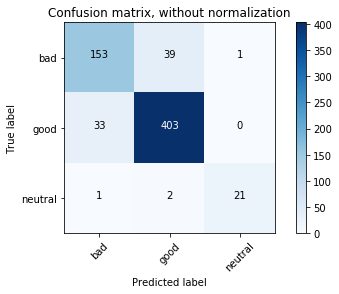

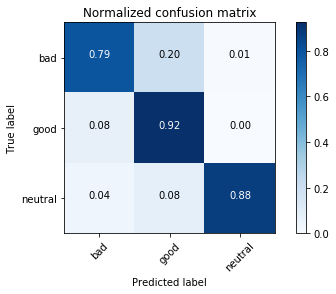

In [36]:
generate_confusion_matrix(expected_results, results, LABELS)

# Superheroes linear classifier train

In [48]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings/linear-classifier/test08/model/1528372522"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/linear-classifier/test08",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [49]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/linear-classifier/test08",
                            "data","actual_trainset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]
df = df[df["Alignment"].isin(["good","bad","neutral"]) ]
#df = df.drop(["Publisher"], axis=1)
for c in COLUMNS:
    if df[c].dtypes.name == 'bool':
        df[c]=df[c].map({True: 'TRUE', False: 'FALSE'})

In [50]:
BATCH_SIZE=15
heroes=list(df["index"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(heroes):
    feats=list(df[df["index"]==h].drop(["Alignment"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["index"]==h]["Alignment"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"superheroes":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading superheroes from gs://ml-research-injenia/estimators/trainings/linear-classifier/test08/model/1528372522 to ./tensorflow_model_server_staging/superheroes
model superheroes downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/superheroes
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 14:22:49.748304: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 14:22:49.748355: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: superheroes

2018-06-07 14:22:49.848801: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: superheroes version: 1}

2018-06-07 14:22:49.848833: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: superheroes version: 1}

2018-06-07 14:22:49.848841: I tensorflow_serving/core/loader_harness.c

Confusion matrix, without normalization
[[130  43   1]
 [ 14 379   0]
 [  0   3  19]]
Normalized confusion matrix
[[0.75 0.25 0.01]
 [0.04 0.96 0.  ]
 [0.   0.14 0.86]]


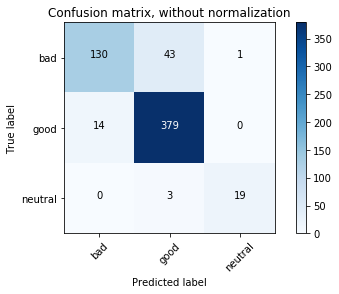

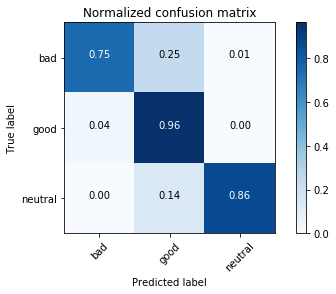

In [51]:
generate_confusion_matrix(expected_results, results, LABELS)

# Superheroes linear classifier eval

In [41]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings/linear-classifier/test08/model/1528372522"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/linear-classifier/test08",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [42]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/linear-classifier/test08",
                            "data","actual_evalset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]
df = df[df["Alignment"].isin(["good","bad","neutral"]) ]
#df = df.drop(["Publisher"], axis=1)
for c in COLUMNS:
    if df[c].dtypes.name == 'bool':
        df[c]=df[c].map({True: 'TRUE', False: 'FALSE'})

In [43]:
def extract_outcomes(predictions):
    for p in predictions:
        if(not p["superheroes"]["success"]):
            print(p)
            raise
    
    return [p["superheroes"]["result"]["classes"][np.argmax(
        p["superheroes"]["result"]["scores"]
    )] for p in predictions]

In [44]:
BATCH_SIZE=15
heroes=list(df["index"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(heroes):
    feats=list(df[df["index"]==h].drop(["Alignment"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["index"]==h]["Alignment"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"superheroes":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading superheroes from gs://ml-research-injenia/estimators/trainings/linear-classifier/test08/model/1528372522 to ./tensorflow_model_server_staging/superheroes
model superheroes downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/superheroes
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 14:19:57.771401: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 14:19:57.771464: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: superheroes

2018-06-07 14:19:57.871853: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: superheroes version: 1}

2018-06-07 14:19:57.871884: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: superheroes version: 1}

2018-06-07 14:19:57.871893: I tensorflow_serving/core/loader_harness.c

In [45]:
correct=0
total=0
for i,result in enumerate(results):
    if result==expected_results[i]:
        correct+=1
    total+=1
print("Accuracy:")
print(float(correct)/float(total))

Accuracy:
0.671875


In [46]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_confusion_matrix(y_test, y_pred, class_names):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[ 8 10  1]
 [ 7 35  1]
 [ 1  1  0]]
Normalized confusion matrix
[[0.42 0.53 0.05]
 [0.16 0.81 0.02]
 [0.5  0.5  0.  ]]


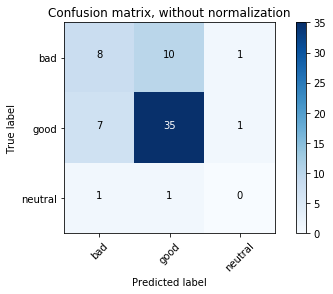

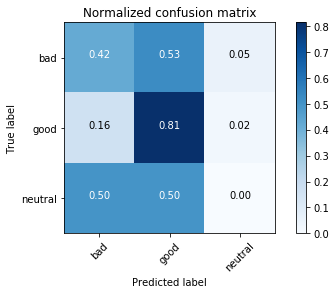

In [47]:
generate_confusion_matrix(expected_results, results, LABELS)

# Superheroes DNN classifier train

In [52]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07/model/1528381144"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [53]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07",
                            "data","actual_trainset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]
df = df[df["Alignment"].isin(["good","bad","neutral"]) ]
#df = df.drop(["Publisher"], axis=1)
for c in COLUMNS:
    if df[c].dtypes.name == 'bool':
        df[c]=df[c].map({True: 'TRUE', False: 'FALSE'})

In [54]:
BATCH_SIZE=15
heroes=list(df["index"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(heroes):
    feats=list(df[df["index"]==h].drop(["Alignment"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["index"]==h]["Alignment"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"superheroes":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading superheroes from gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07/model/1528381144 to ./tensorflow_model_server_staging/superheroes
model superheroes downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/superheroes
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 14:31:47.191577: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 14:31:47.191633: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: superheroes

2018-06-07 14:31:47.292123: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: superheroes version: 1}

2018-06-07 14:31:47.292161: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: superheroes version: 1}

2018-06-07 14:31:47.292170: I tensorflow_serving/core/loader_harness.cc:7

Confusion matrix, without normalization
[[173   1   0]
 [  0 393   0]
 [  0   0  22]]
Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]]


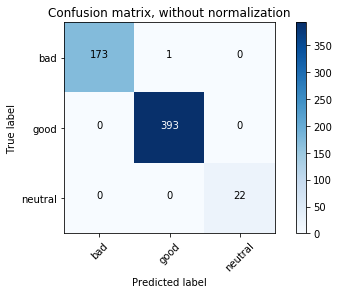

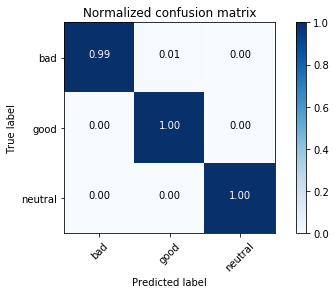

In [55]:
generate_confusion_matrix(expected_results, results, LABELS)

# Superheroes DNN classifier eval

In [56]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07/model/1528381144"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [57]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07",
                            "data","actual_evalset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]
df = df[df["Alignment"].isin(["good","bad","neutral"]) ]
#df = df.drop(["Publisher"], axis=1)
for c in COLUMNS:
    if df[c].dtypes.name == 'bool':
        df[c]=df[c].map({True: 'TRUE', False: 'FALSE'})

In [58]:
BATCH_SIZE=15
heroes=list(df["index"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(heroes):
    feats=list(df[df["index"]==h].drop(["Alignment"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["index"]==h]["Alignment"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"superheroes":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading superheroes from gs://ml-research-injenia/estimators/trainings/dnn-classifier/test07/model/1528381144 to ./tensorflow_model_server_staging/superheroes
model superheroes downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/superheroes
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 14:32:51.711446: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 14:32:51.711496: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: superheroes

2018-06-07 14:32:51.811886: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: superheroes version: 1}

2018-06-07 14:32:51.811930: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: superheroes version: 1}

2018-06-07 14:32:51.811942: I tensorflow_serving/core/loader_harness.cc:7

Confusion matrix, without normalization
[[ 8 10  1]
 [12 31  0]
 [ 1  1  0]]
Normalized confusion matrix
[[0.42 0.53 0.05]
 [0.28 0.72 0.  ]
 [0.5  0.5  0.  ]]


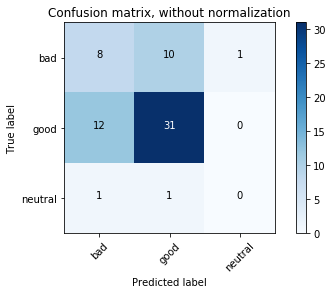

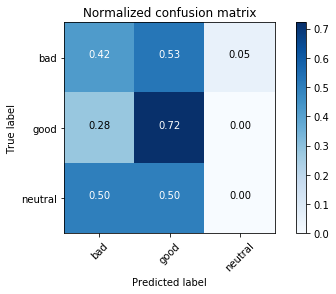

In [59]:
generate_confusion_matrix(expected_results, results, LABELS)

# --------------------------------------------------------------

# Kickstarter

# ---------------------------------------------------------------

In [67]:
def extract_outcomes(predictions):
    for p in predictions:
        if(not p["kickstarter"]["success"]):
            print(p)
            raise
    
    return [p["kickstarter"]["result"]["classes"][np.argmax(
        p["kickstarter"]["result"]["scores"]
    )] for p in predictions]

# Kickstarter linear classifier train

In [61]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05/model/1528280996"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [63]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05",
                            "data","actual_trainset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]

In [66]:
df

,ID,category,main_category,state,country,timespan_days_scaled,goal_USD_scaled,goal_USD_log_scaled
0,1892252564,Comic Books,Comics,successful,US,-0.308155,-0.036034,-0.453981
1,1569410360,Documentary,Film & Video,failed,US,2.019002,-0.036501,-0.587792
2,703720557,Illustration,Art,failed,US,-0.308155,-0.035847,-0.407830
3,296713470,Photography,Photography,successful,US,-0.308155,-0.033698,-0.038326
4,156448762,Product Design,Design,failed,US,-0.308155,-0.024352,0.620471
5,1255814383,Music,Music,successful,US,-0.308155,0.055088,1.758104
6,697900694,Video Games,Games,failed,CA,-0.308155,-0.037249,-0.894384
7,1026864342,Civic Design,Design,failed,IT,2.019002,-0.015073,0.925065
8,1923292016,Farmer's Markets,Food,failed,GB,-0.696015,-0.038239,-2.180931
9,317811128,Publishing,Publishing,failed,US,-0.385727,-0.024352,0.620471


In [71]:
BATCH_SIZE=15
ids=list(df["ID"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(ids):
    feats=list(df[df["ID"]==h].drop(["state"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["ID"]==h]["state"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"kickstarter":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading kickstarter from gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05/model/1528280996 to ./tensorflow_model_server_staging/kickstarter
model kickstarter downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/kickstarter
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 15:04:48.173697: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 15:04:48.173748: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: kickstarter

2018-06-07 15:04:48.274139: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: kickstarter version: 1}

2018-06-07 15:04:48.274172: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: kickstarter version: 1}

2018-06-07 15:04:48.274181: I tensorflow_serving/core/load

(452, 16879)
(453, 16879)
(454, 16879)
(455, 16879)
(456, 16879)
(457, 16879)
(458, 16879)
(459, 16879)
(460, 16879)
(461, 16879)
(462, 16879)
(463, 16879)
(464, 16879)
(465, 16879)
(466, 16879)
(467, 16879)
(468, 16879)
(469, 16879)
(470, 16879)
(471, 16879)
(472, 16879)
(473, 16879)
(474, 16879)
(475, 16879)
(476, 16879)
(477, 16879)
(478, 16879)
(479, 16879)
(480, 16879)
(481, 16879)
(482, 16879)
(483, 16879)
(484, 16879)
(485, 16879)
(486, 16879)
(487, 16879)
(488, 16879)
(489, 16879)
(490, 16879)
(491, 16879)
(492, 16879)
(493, 16879)
(494, 16879)
(495, 16879)
(496, 16879)
(497, 16879)
(498, 16879)
(499, 16879)
(500, 16879)
(501, 16879)
(502, 16879)
(503, 16879)
(504, 16879)
(505, 16879)
(506, 16879)
(507, 16879)
(508, 16879)
(509, 16879)
(510, 16879)
(511, 16879)
(512, 16879)
(513, 16879)
(514, 16879)
(515, 16879)
(516, 16879)
(517, 16879)
(518, 16879)
(519, 16879)
(520, 16879)
(521, 16879)
(522, 16879)
(523, 16879)
(524, 16879)
(525, 16879)
(526, 16879)
(527, 16879)
(528, 16879)

(1077, 16879)
(1078, 16879)
(1079, 16879)
(1080, 16879)
(1081, 16879)
(1082, 16879)
(1083, 16879)
(1084, 16879)
(1085, 16879)
(1086, 16879)
(1087, 16879)
(1088, 16879)
(1089, 16879)
(1090, 16879)
(1091, 16879)
(1092, 16879)
(1093, 16879)
(1094, 16879)
(1095, 16879)
(1096, 16879)
(1097, 16879)
(1098, 16879)
(1099, 16879)
(1100, 16879)
(1101, 16879)
(1102, 16879)
(1103, 16879)
(1104, 16879)
(1105, 16879)
(1106, 16879)
(1107, 16879)
(1108, 16879)
(1109, 16879)
(1110, 16879)
(1111, 16879)
(1112, 16879)
(1113, 16879)
(1114, 16879)
(1115, 16879)
(1116, 16879)
(1117, 16879)
(1118, 16879)
(1119, 16879)
(1120, 16879)
(1121, 16879)
(1122, 16879)
(1123, 16879)
(1124, 16879)
(1125, 16879)
(1126, 16879)
(1127, 16879)
(1128, 16879)
(1129, 16879)
(1130, 16879)
(1131, 16879)
(1132, 16879)
(1133, 16879)
(1134, 16879)
(1135, 16879)
(1136, 16879)
(1137, 16879)
(1138, 16879)
(1139, 16879)
(1140, 16879)
(1141, 16879)
(1142, 16879)
(1143, 16879)
(1144, 16879)
(1145, 16879)
(1146, 16879)
(1147, 16879)
(1148,

(1663, 16879)
(1664, 16879)
(1665, 16879)
(1666, 16879)
(1667, 16879)
(1668, 16879)
(1669, 16879)
(1670, 16879)
(1671, 16879)
(1672, 16879)
(1673, 16879)
(1674, 16879)
(1675, 16879)
(1676, 16879)
(1677, 16879)
(1678, 16879)
(1679, 16879)
(1680, 16879)
(1681, 16879)
(1682, 16879)
(1683, 16879)
(1684, 16879)
(1685, 16879)
(1686, 16879)
(1687, 16879)
(1688, 16879)
(1689, 16879)
(1690, 16879)
(1691, 16879)
(1692, 16879)
(1693, 16879)
(1694, 16879)
(1695, 16879)
(1696, 16879)
(1697, 16879)
(1698, 16879)
(1699, 16879)
(1700, 16879)
(1701, 16879)
(1702, 16879)
(1703, 16879)
(1704, 16879)
(1705, 16879)
(1706, 16879)
(1707, 16879)
(1708, 16879)
(1709, 16879)
(1710, 16879)
(1711, 16879)
(1712, 16879)
(1713, 16879)
(1714, 16879)
(1715, 16879)
(1716, 16879)
(1717, 16879)
(1718, 16879)
(1719, 16879)
(1720, 16879)
(1721, 16879)
(1722, 16879)
(1723, 16879)
(1724, 16879)
(1725, 16879)
(1726, 16879)
(1727, 16879)
(1728, 16879)
(1729, 16879)
(1730, 16879)
(1731, 16879)
(1732, 16879)
(1733, 16879)
(1734,

(2249, 16879)
(2250, 16879)
(2251, 16879)
(2252, 16879)
(2253, 16879)
(2254, 16879)
(2255, 16879)
(2256, 16879)
(2257, 16879)
(2258, 16879)
(2259, 16879)
(2260, 16879)
(2261, 16879)
(2262, 16879)
(2263, 16879)
(2264, 16879)
(2265, 16879)
(2266, 16879)
(2267, 16879)
(2268, 16879)
(2269, 16879)
(2270, 16879)
(2271, 16879)
(2272, 16879)
(2273, 16879)
(2274, 16879)
(2275, 16879)
(2276, 16879)
(2277, 16879)
(2278, 16879)
(2279, 16879)
(2280, 16879)
(2281, 16879)
(2282, 16879)
(2283, 16879)
(2284, 16879)
(2285, 16879)
(2286, 16879)
(2287, 16879)
(2288, 16879)
(2289, 16879)
(2290, 16879)
(2291, 16879)
(2292, 16879)
(2293, 16879)
(2294, 16879)
(2295, 16879)
(2296, 16879)
(2297, 16879)
(2298, 16879)
(2299, 16879)
(2300, 16879)
(2301, 16879)
(2302, 16879)
(2303, 16879)
(2304, 16879)
(2305, 16879)
(2306, 16879)
(2307, 16879)
(2308, 16879)
(2309, 16879)
(2310, 16879)
(2311, 16879)
(2312, 16879)
(2313, 16879)
(2314, 16879)
(2315, 16879)
(2316, 16879)
(2317, 16879)
(2318, 16879)
(2319, 16879)
(2320,

(2835, 16879)
(2836, 16879)
(2837, 16879)
(2838, 16879)
(2839, 16879)
(2840, 16879)
(2841, 16879)
(2842, 16879)
(2843, 16879)
(2844, 16879)
(2845, 16879)
(2846, 16879)
(2847, 16879)
(2848, 16879)
(2849, 16879)
(2850, 16879)
(2851, 16879)
(2852, 16879)
(2853, 16879)
(2854, 16879)
(2855, 16879)
(2856, 16879)
(2857, 16879)
(2858, 16879)
(2859, 16879)
(2860, 16879)
(2861, 16879)
(2862, 16879)
(2863, 16879)
(2864, 16879)
(2865, 16879)
(2866, 16879)
(2867, 16879)
(2868, 16879)
(2869, 16879)
(2870, 16879)
(2871, 16879)
(2872, 16879)
(2873, 16879)
(2874, 16879)
(2875, 16879)
(2876, 16879)
(2877, 16879)
(2878, 16879)
(2879, 16879)
(2880, 16879)
(2881, 16879)
(2882, 16879)
(2883, 16879)
(2884, 16879)
(2885, 16879)
(2886, 16879)
(2887, 16879)
(2888, 16879)
(2889, 16879)
(2890, 16879)
(2891, 16879)
(2892, 16879)
(2893, 16879)
(2894, 16879)
(2895, 16879)
(2896, 16879)
(2897, 16879)
(2898, 16879)
(2899, 16879)
(2900, 16879)
(2901, 16879)
(2902, 16879)
(2903, 16879)
(2904, 16879)
(2905, 16879)
(2906,

(3421, 16879)
(3422, 16879)
(3423, 16879)
(3424, 16879)
(3425, 16879)
(3426, 16879)
(3427, 16879)
(3428, 16879)
(3429, 16879)
(3430, 16879)
(3431, 16879)
(3432, 16879)
(3433, 16879)
(3434, 16879)
(3435, 16879)
(3436, 16879)
(3437, 16879)
(3438, 16879)
(3439, 16879)
(3440, 16879)
(3441, 16879)
(3442, 16879)
(3443, 16879)
(3444, 16879)
(3445, 16879)
(3446, 16879)
(3447, 16879)
(3448, 16879)
(3449, 16879)
(3450, 16879)
(3451, 16879)
(3452, 16879)
(3453, 16879)
(3454, 16879)
(3455, 16879)
(3456, 16879)
(3457, 16879)
(3458, 16879)
(3459, 16879)
(3460, 16879)
(3461, 16879)
(3462, 16879)
(3463, 16879)
(3464, 16879)
(3465, 16879)
(3466, 16879)
(3467, 16879)
(3468, 16879)
(3469, 16879)
(3470, 16879)
(3471, 16879)
(3472, 16879)
(3473, 16879)
(3474, 16879)
(3475, 16879)
(3476, 16879)
(3477, 16879)
(3478, 16879)
(3479, 16879)
(3480, 16879)
(3481, 16879)
(3482, 16879)
(3483, 16879)
(3484, 16879)
(3485, 16879)
(3486, 16879)
(3487, 16879)
(3488, 16879)
(3489, 16879)
(3490, 16879)
(3491, 16879)
(3492,

(4007, 16879)
(4008, 16879)
(4009, 16879)
(4010, 16879)
(4011, 16879)
(4012, 16879)
(4013, 16879)
(4014, 16879)
(4015, 16879)
(4016, 16879)
(4017, 16879)
(4018, 16879)
(4019, 16879)
(4020, 16879)
(4021, 16879)
(4022, 16879)
(4023, 16879)
(4024, 16879)
(4025, 16879)
(4026, 16879)
(4027, 16879)
(4028, 16879)
(4029, 16879)
(4030, 16879)
(4031, 16879)
(4032, 16879)
(4033, 16879)
(4034, 16879)
(4035, 16879)
(4036, 16879)
(4037, 16879)
(4038, 16879)
(4039, 16879)
(4040, 16879)
(4041, 16879)
(4042, 16879)
(4043, 16879)
(4044, 16879)
(4045, 16879)
(4046, 16879)
(4047, 16879)
(4048, 16879)
(4049, 16879)
(4050, 16879)
(4051, 16879)
(4052, 16879)
(4053, 16879)
(4054, 16879)
(4055, 16879)
(4056, 16879)
(4057, 16879)
(4058, 16879)
(4059, 16879)
(4060, 16879)
(4061, 16879)
(4062, 16879)
(4063, 16879)
(4064, 16879)
(4065, 16879)
(4066, 16879)
(4067, 16879)
(4068, 16879)
(4069, 16879)
(4070, 16879)
(4071, 16879)
(4072, 16879)
(4073, 16879)
(4074, 16879)
(4075, 16879)
(4076, 16879)
(4077, 16879)
(4078,

(4593, 16879)
(4594, 16879)
(4595, 16879)
(4596, 16879)
(4597, 16879)
(4598, 16879)
(4599, 16879)
(4600, 16879)
(4601, 16879)
(4602, 16879)
(4603, 16879)
(4604, 16879)
(4605, 16879)
(4606, 16879)
(4607, 16879)
(4608, 16879)
(4609, 16879)
(4610, 16879)
(4611, 16879)
(4612, 16879)
(4613, 16879)
(4614, 16879)
(4615, 16879)
(4616, 16879)
(4617, 16879)
(4618, 16879)
(4619, 16879)
(4620, 16879)
(4621, 16879)
(4622, 16879)
(4623, 16879)
(4624, 16879)
(4625, 16879)
(4626, 16879)
(4627, 16879)
(4628, 16879)
(4629, 16879)
(4630, 16879)
(4631, 16879)
(4632, 16879)
(4633, 16879)
(4634, 16879)
(4635, 16879)
(4636, 16879)
(4637, 16879)
(4638, 16879)
(4639, 16879)
(4640, 16879)
(4641, 16879)
(4642, 16879)
(4643, 16879)
(4644, 16879)
(4645, 16879)
(4646, 16879)
(4647, 16879)
(4648, 16879)
(4649, 16879)
(4650, 16879)
(4651, 16879)
(4652, 16879)
(4653, 16879)
(4654, 16879)
(4655, 16879)
(4656, 16879)
(4657, 16879)
(4658, 16879)
(4659, 16879)
(4660, 16879)
(4661, 16879)
(4662, 16879)
(4663, 16879)
(4664,

(5179, 16879)
(5180, 16879)
(5181, 16879)
(5182, 16879)
(5183, 16879)
(5184, 16879)
(5185, 16879)
(5186, 16879)
(5187, 16879)
(5188, 16879)
(5189, 16879)
(5190, 16879)
(5191, 16879)
(5192, 16879)
(5193, 16879)
(5194, 16879)
(5195, 16879)
(5196, 16879)
(5197, 16879)
(5198, 16879)
(5199, 16879)
(5200, 16879)
(5201, 16879)
(5202, 16879)
(5203, 16879)
(5204, 16879)
(5205, 16879)
(5206, 16879)
(5207, 16879)
(5208, 16879)
(5209, 16879)
(5210, 16879)
(5211, 16879)
(5212, 16879)
(5213, 16879)
(5214, 16879)
(5215, 16879)
(5216, 16879)
(5217, 16879)
(5218, 16879)
(5219, 16879)
(5220, 16879)
(5221, 16879)
(5222, 16879)
(5223, 16879)
(5224, 16879)
(5225, 16879)
(5226, 16879)
(5227, 16879)
(5228, 16879)
(5229, 16879)
(5230, 16879)
(5231, 16879)
(5232, 16879)
(5233, 16879)
(5234, 16879)
(5235, 16879)
(5236, 16879)
(5237, 16879)
(5238, 16879)
(5239, 16879)
(5240, 16879)
(5241, 16879)
(5242, 16879)
(5243, 16879)
(5244, 16879)
(5245, 16879)
(5246, 16879)
(5247, 16879)
(5248, 16879)
(5249, 16879)
(5250,

(5765, 16879)
(5766, 16879)
(5767, 16879)
(5768, 16879)
(5769, 16879)
(5770, 16879)
(5771, 16879)
(5772, 16879)
(5773, 16879)
(5774, 16879)
(5775, 16879)
(5776, 16879)
(5777, 16879)
(5778, 16879)
(5779, 16879)
(5780, 16879)
(5781, 16879)
(5782, 16879)
(5783, 16879)
(5784, 16879)
(5785, 16879)
(5786, 16879)
(5787, 16879)
(5788, 16879)
(5789, 16879)
(5790, 16879)
(5791, 16879)
(5792, 16879)
(5793, 16879)
(5794, 16879)
(5795, 16879)
(5796, 16879)
(5797, 16879)
(5798, 16879)
(5799, 16879)
(5800, 16879)
(5801, 16879)
(5802, 16879)
(5803, 16879)
(5804, 16879)
(5805, 16879)
(5806, 16879)
(5807, 16879)
(5808, 16879)
(5809, 16879)
(5810, 16879)
(5811, 16879)
(5812, 16879)
(5813, 16879)
(5814, 16879)
(5815, 16879)
(5816, 16879)
(5817, 16879)
(5818, 16879)
(5819, 16879)
(5820, 16879)
(5821, 16879)
(5822, 16879)
(5823, 16879)
(5824, 16879)
(5825, 16879)
(5826, 16879)
(5827, 16879)
(5828, 16879)
(5829, 16879)
(5830, 16879)
(5831, 16879)
(5832, 16879)
(5833, 16879)
(5834, 16879)
(5835, 16879)
(5836,

(6351, 16879)
(6352, 16879)
(6353, 16879)
(6354, 16879)
(6355, 16879)
(6356, 16879)
(6357, 16879)
(6358, 16879)
(6359, 16879)
(6360, 16879)
(6361, 16879)
(6362, 16879)
(6363, 16879)
(6364, 16879)
(6365, 16879)
(6366, 16879)
(6367, 16879)
(6368, 16879)
(6369, 16879)
(6370, 16879)
(6371, 16879)
(6372, 16879)
(6373, 16879)
(6374, 16879)
(6375, 16879)
(6376, 16879)
(6377, 16879)
(6378, 16879)
(6379, 16879)
(6380, 16879)
(6381, 16879)
(6382, 16879)
(6383, 16879)
(6384, 16879)
(6385, 16879)
(6386, 16879)
(6387, 16879)
(6388, 16879)
(6389, 16879)
(6390, 16879)
(6391, 16879)
(6392, 16879)
(6393, 16879)
(6394, 16879)
(6395, 16879)
(6396, 16879)
(6397, 16879)
(6398, 16879)
(6399, 16879)
(6400, 16879)
(6401, 16879)
(6402, 16879)
(6403, 16879)
(6404, 16879)
(6405, 16879)
(6406, 16879)
(6407, 16879)
(6408, 16879)
(6409, 16879)
(6410, 16879)
(6411, 16879)
(6412, 16879)
(6413, 16879)
(6414, 16879)
(6415, 16879)
(6416, 16879)
(6417, 16879)
(6418, 16879)
(6419, 16879)
(6420, 16879)
(6421, 16879)
(6422,

(6937, 16879)
(6938, 16879)
(6939, 16879)
(6940, 16879)
(6941, 16879)
(6942, 16879)
(6943, 16879)
(6944, 16879)
(6945, 16879)
(6946, 16879)
(6947, 16879)
(6948, 16879)
(6949, 16879)
(6950, 16879)
(6951, 16879)
(6952, 16879)
(6953, 16879)
(6954, 16879)
(6955, 16879)
(6956, 16879)
(6957, 16879)
(6958, 16879)
(6959, 16879)
(6960, 16879)
(6961, 16879)
(6962, 16879)
(6963, 16879)
(6964, 16879)
(6965, 16879)
(6966, 16879)
(6967, 16879)
(6968, 16879)
(6969, 16879)
(6970, 16879)
(6971, 16879)
(6972, 16879)
(6973, 16879)
(6974, 16879)
(6975, 16879)
(6976, 16879)
(6977, 16879)
(6978, 16879)
(6979, 16879)
(6980, 16879)
(6981, 16879)
(6982, 16879)
(6983, 16879)
(6984, 16879)
(6985, 16879)
(6986, 16879)
(6987, 16879)
(6988, 16879)
(6989, 16879)
(6990, 16879)
(6991, 16879)
(6992, 16879)
(6993, 16879)
(6994, 16879)
(6995, 16879)
(6996, 16879)
(6997, 16879)
(6998, 16879)
(6999, 16879)
(7000, 16879)
(7001, 16879)
(7002, 16879)
(7003, 16879)
(7004, 16879)
(7005, 16879)
(7006, 16879)
(7007, 16879)
(7008,

(7523, 16879)
(7524, 16879)
(7525, 16879)
(7526, 16879)
(7527, 16879)
(7528, 16879)
(7529, 16879)
(7530, 16879)
(7531, 16879)
(7532, 16879)
(7533, 16879)
(7534, 16879)
(7535, 16879)
(7536, 16879)
(7537, 16879)
(7538, 16879)
(7539, 16879)
(7540, 16879)
(7541, 16879)
(7542, 16879)
(7543, 16879)
(7544, 16879)
(7545, 16879)
(7546, 16879)
(7547, 16879)
(7548, 16879)
(7549, 16879)
(7550, 16879)
(7551, 16879)
(7552, 16879)
(7553, 16879)
(7554, 16879)
(7555, 16879)
(7556, 16879)
(7557, 16879)
(7558, 16879)
(7559, 16879)
(7560, 16879)
(7561, 16879)
(7562, 16879)
(7563, 16879)
(7564, 16879)
(7565, 16879)
(7566, 16879)
(7567, 16879)
(7568, 16879)
(7569, 16879)
(7570, 16879)
(7571, 16879)
(7572, 16879)
(7573, 16879)
(7574, 16879)
(7575, 16879)
(7576, 16879)
(7577, 16879)
(7578, 16879)
(7579, 16879)
(7580, 16879)
(7581, 16879)
(7582, 16879)
(7583, 16879)
(7584, 16879)
(7585, 16879)
(7586, 16879)
(7587, 16879)
(7588, 16879)
(7589, 16879)
(7590, 16879)
(7591, 16879)
(7592, 16879)
(7593, 16879)
(7594,

(8109, 16879)
(8110, 16879)
(8111, 16879)
(8112, 16879)
(8113, 16879)
(8114, 16879)
(8115, 16879)
(8116, 16879)
(8117, 16879)
(8118, 16879)
(8119, 16879)
(8120, 16879)
(8121, 16879)
(8122, 16879)
(8123, 16879)
(8124, 16879)
(8125, 16879)
(8126, 16879)
(8127, 16879)
(8128, 16879)
(8129, 16879)
(8130, 16879)
(8131, 16879)
(8132, 16879)
(8133, 16879)
(8134, 16879)
(8135, 16879)
(8136, 16879)
(8137, 16879)
(8138, 16879)
(8139, 16879)
(8140, 16879)
(8141, 16879)
(8142, 16879)
(8143, 16879)
(8144, 16879)
(8145, 16879)
(8146, 16879)
(8147, 16879)
(8148, 16879)
(8149, 16879)
(8150, 16879)
(8151, 16879)
(8152, 16879)
(8153, 16879)
(8154, 16879)
(8155, 16879)
(8156, 16879)
(8157, 16879)
(8158, 16879)
(8159, 16879)
(8160, 16879)
(8161, 16879)
(8162, 16879)
(8163, 16879)
(8164, 16879)
(8165, 16879)
(8166, 16879)
(8167, 16879)
(8168, 16879)
(8169, 16879)
(8170, 16879)
(8171, 16879)
(8172, 16879)
(8173, 16879)
(8174, 16879)
(8175, 16879)
(8176, 16879)
(8177, 16879)
(8178, 16879)
(8179, 16879)
(8180,

(8695, 16879)
(8696, 16879)
(8697, 16879)
(8698, 16879)
(8699, 16879)
(8700, 16879)
(8701, 16879)
(8702, 16879)
(8703, 16879)
(8704, 16879)
(8705, 16879)
(8706, 16879)
(8707, 16879)
(8708, 16879)
(8709, 16879)
(8710, 16879)
(8711, 16879)
(8712, 16879)
(8713, 16879)
(8714, 16879)
(8715, 16879)
(8716, 16879)
(8717, 16879)
(8718, 16879)
(8719, 16879)
(8720, 16879)
(8721, 16879)
(8722, 16879)
(8723, 16879)
(8724, 16879)
(8725, 16879)
(8726, 16879)
(8727, 16879)
(8728, 16879)
(8729, 16879)
(8730, 16879)
(8731, 16879)
(8732, 16879)
(8733, 16879)
(8734, 16879)
(8735, 16879)
(8736, 16879)
(8737, 16879)
(8738, 16879)
(8739, 16879)
(8740, 16879)
(8741, 16879)
(8742, 16879)
(8743, 16879)
(8744, 16879)
(8745, 16879)
(8746, 16879)
(8747, 16879)
(8748, 16879)
(8749, 16879)
(8750, 16879)
(8751, 16879)
(8752, 16879)
(8753, 16879)
(8754, 16879)
(8755, 16879)
(8756, 16879)
(8757, 16879)
(8758, 16879)
(8759, 16879)
(8760, 16879)
(8761, 16879)
(8762, 16879)
(8763, 16879)
(8764, 16879)
(8765, 16879)
(8766,

(9281, 16879)
(9282, 16879)
(9283, 16879)
(9284, 16879)
(9285, 16879)
(9286, 16879)
(9287, 16879)
(9288, 16879)
(9289, 16879)
(9290, 16879)
(9291, 16879)
(9292, 16879)
(9293, 16879)
(9294, 16879)
(9295, 16879)
(9296, 16879)
(9297, 16879)
(9298, 16879)
(9299, 16879)
(9300, 16879)
(9301, 16879)
(9302, 16879)
(9303, 16879)
(9304, 16879)
(9305, 16879)
(9306, 16879)
(9307, 16879)
(9308, 16879)
(9309, 16879)
(9310, 16879)
(9311, 16879)
(9312, 16879)
(9313, 16879)
(9314, 16879)
(9315, 16879)
(9316, 16879)
(9317, 16879)
(9318, 16879)
(9319, 16879)
(9320, 16879)
(9321, 16879)
(9322, 16879)
(9323, 16879)
(9324, 16879)
(9325, 16879)
(9326, 16879)
(9327, 16879)
(9328, 16879)
(9329, 16879)
(9330, 16879)
(9331, 16879)
(9332, 16879)
(9333, 16879)
(9334, 16879)
(9335, 16879)
(9336, 16879)
(9337, 16879)
(9338, 16879)
(9339, 16879)
(9340, 16879)
(9341, 16879)
(9342, 16879)
(9343, 16879)
(9344, 16879)
(9345, 16879)
(9346, 16879)
(9347, 16879)
(9348, 16879)
(9349, 16879)
(9350, 16879)
(9351, 16879)
(9352,

(9867, 16879)
(9868, 16879)
(9869, 16879)
(9870, 16879)
(9871, 16879)
(9872, 16879)
(9873, 16879)
(9874, 16879)
(9875, 16879)
(9876, 16879)
(9877, 16879)
(9878, 16879)
(9879, 16879)
(9880, 16879)
(9881, 16879)
(9882, 16879)
(9883, 16879)
(9884, 16879)
(9885, 16879)
(9886, 16879)
(9887, 16879)
(9888, 16879)
(9889, 16879)
(9890, 16879)
(9891, 16879)
(9892, 16879)
(9893, 16879)
(9894, 16879)
(9895, 16879)
(9896, 16879)
(9897, 16879)
(9898, 16879)
(9899, 16879)
(9900, 16879)
(9901, 16879)
(9902, 16879)
(9903, 16879)
(9904, 16879)
(9905, 16879)
(9906, 16879)
(9907, 16879)
(9908, 16879)
(9909, 16879)
(9910, 16879)
(9911, 16879)
(9912, 16879)
(9913, 16879)
(9914, 16879)
(9915, 16879)
(9916, 16879)
(9917, 16879)
(9918, 16879)
(9919, 16879)
(9920, 16879)
(9921, 16879)
(9922, 16879)
(9923, 16879)
(9924, 16879)
(9925, 16879)
(9926, 16879)
(9927, 16879)
(9928, 16879)
(9929, 16879)
(9930, 16879)
(9931, 16879)
(9932, 16879)
(9933, 16879)
(9934, 16879)
(9935, 16879)
(9936, 16879)
(9937, 16879)
(9938,

(10423, 16879)
(10424, 16879)
(10425, 16879)
(10426, 16879)
(10427, 16879)
(10428, 16879)
(10429, 16879)
(10430, 16879)
(10431, 16879)
(10432, 16879)
(10433, 16879)
(10434, 16879)
(10435, 16879)
(10436, 16879)
(10437, 16879)
(10438, 16879)
(10439, 16879)
(10440, 16879)
(10441, 16879)
(10442, 16879)
(10443, 16879)
(10444, 16879)
(10445, 16879)
(10446, 16879)
(10447, 16879)
(10448, 16879)
(10449, 16879)
(10450, 16879)
(10451, 16879)
(10452, 16879)
(10453, 16879)
(10454, 16879)
(10455, 16879)
(10456, 16879)
(10457, 16879)
(10458, 16879)
(10459, 16879)
(10460, 16879)
(10461, 16879)
(10462, 16879)
(10463, 16879)
(10464, 16879)
(10465, 16879)
(10466, 16879)
(10467, 16879)
(10468, 16879)
(10469, 16879)
(10470, 16879)
(10471, 16879)
(10472, 16879)
(10473, 16879)
(10474, 16879)
(10475, 16879)
(10476, 16879)
(10477, 16879)
(10478, 16879)
(10479, 16879)
(10480, 16879)
(10481, 16879)
(10482, 16879)
(10483, 16879)
(10484, 16879)
(10485, 16879)
(10486, 16879)
(10487, 16879)
(10488, 16879)
(10489, 16

(10970, 16879)
(10971, 16879)
(10972, 16879)
(10973, 16879)
(10974, 16879)
(10975, 16879)
(10976, 16879)
(10977, 16879)
(10978, 16879)
(10979, 16879)
(10980, 16879)
(10981, 16879)
(10982, 16879)
(10983, 16879)
(10984, 16879)
(10985, 16879)
(10986, 16879)
(10987, 16879)
(10988, 16879)
(10989, 16879)
(10990, 16879)
(10991, 16879)
(10992, 16879)
(10993, 16879)
(10994, 16879)
(10995, 16879)
(10996, 16879)
(10997, 16879)
(10998, 16879)
(10999, 16879)
(11000, 16879)
(11001, 16879)
(11002, 16879)
(11003, 16879)
(11004, 16879)
(11005, 16879)
(11006, 16879)
(11007, 16879)
(11008, 16879)
(11009, 16879)
(11010, 16879)
(11011, 16879)
(11012, 16879)
(11013, 16879)
(11014, 16879)
(11015, 16879)
(11016, 16879)
(11017, 16879)
(11018, 16879)
(11019, 16879)
(11020, 16879)
(11021, 16879)
(11022, 16879)
(11023, 16879)
(11024, 16879)
(11025, 16879)
(11026, 16879)
(11027, 16879)
(11028, 16879)
(11029, 16879)
(11030, 16879)
(11031, 16879)
(11032, 16879)
(11033, 16879)
(11034, 16879)
(11035, 16879)
(11036, 16

(11517, 16879)
(11518, 16879)
(11519, 16879)
(11520, 16879)
(11521, 16879)
(11522, 16879)
(11523, 16879)
(11524, 16879)
(11525, 16879)
(11526, 16879)
(11527, 16879)
(11528, 16879)
(11529, 16879)
(11530, 16879)
(11531, 16879)
(11532, 16879)
(11533, 16879)
(11534, 16879)
(11535, 16879)
(11536, 16879)
(11537, 16879)
(11538, 16879)
(11539, 16879)
(11540, 16879)
(11541, 16879)
(11542, 16879)
(11543, 16879)
(11544, 16879)
(11545, 16879)
(11546, 16879)
(11547, 16879)
(11548, 16879)
(11549, 16879)
(11550, 16879)
(11551, 16879)
(11552, 16879)
(11553, 16879)
(11554, 16879)
(11555, 16879)
(11556, 16879)
(11557, 16879)
(11558, 16879)
(11559, 16879)
(11560, 16879)
(11561, 16879)
(11562, 16879)
(11563, 16879)
(11564, 16879)
(11565, 16879)
(11566, 16879)
(11567, 16879)
(11568, 16879)
(11569, 16879)
(11570, 16879)
(11571, 16879)
(11572, 16879)
(11573, 16879)
(11574, 16879)
(11575, 16879)
(11576, 16879)
(11577, 16879)
(11578, 16879)
(11579, 16879)
(11580, 16879)
(11581, 16879)
(11582, 16879)
(11583, 16

(12064, 16879)
(12065, 16879)
(12066, 16879)
(12067, 16879)
(12068, 16879)
(12069, 16879)
(12070, 16879)
(12071, 16879)
(12072, 16879)
(12073, 16879)
(12074, 16879)
(12075, 16879)
(12076, 16879)
(12077, 16879)
(12078, 16879)
(12079, 16879)
(12080, 16879)
(12081, 16879)
(12082, 16879)
(12083, 16879)
(12084, 16879)
(12085, 16879)
(12086, 16879)
(12087, 16879)
(12088, 16879)
(12089, 16879)
(12090, 16879)
(12091, 16879)
(12092, 16879)
(12093, 16879)
(12094, 16879)
(12095, 16879)
(12096, 16879)
(12097, 16879)
(12098, 16879)
(12099, 16879)
(12100, 16879)
(12101, 16879)
(12102, 16879)
(12103, 16879)
(12104, 16879)
(12105, 16879)
(12106, 16879)
(12107, 16879)
(12108, 16879)
(12109, 16879)
(12110, 16879)
(12111, 16879)
(12112, 16879)
(12113, 16879)
(12114, 16879)
(12115, 16879)
(12116, 16879)
(12117, 16879)
(12118, 16879)
(12119, 16879)
(12120, 16879)
(12121, 16879)
(12122, 16879)
(12123, 16879)
(12124, 16879)
(12125, 16879)
(12126, 16879)
(12127, 16879)
(12128, 16879)
(12129, 16879)
(12130, 16

(12611, 16879)
(12612, 16879)
(12613, 16879)
(12614, 16879)
(12615, 16879)
(12616, 16879)
(12617, 16879)
(12618, 16879)
(12619, 16879)
(12620, 16879)
(12621, 16879)
(12622, 16879)
(12623, 16879)
(12624, 16879)
(12625, 16879)
(12626, 16879)
(12627, 16879)
(12628, 16879)
(12629, 16879)
(12630, 16879)
(12631, 16879)
(12632, 16879)
(12633, 16879)
(12634, 16879)
(12635, 16879)
(12636, 16879)
(12637, 16879)
(12638, 16879)
(12639, 16879)
(12640, 16879)
(12641, 16879)
(12642, 16879)
(12643, 16879)
(12644, 16879)
(12645, 16879)
(12646, 16879)
(12647, 16879)
(12648, 16879)
(12649, 16879)
(12650, 16879)
(12651, 16879)
(12652, 16879)
(12653, 16879)
(12654, 16879)
(12655, 16879)
(12656, 16879)
(12657, 16879)
(12658, 16879)
(12659, 16879)
(12660, 16879)
(12661, 16879)
(12662, 16879)
(12663, 16879)
(12664, 16879)
(12665, 16879)
(12666, 16879)
(12667, 16879)
(12668, 16879)
(12669, 16879)
(12670, 16879)
(12671, 16879)
(12672, 16879)
(12673, 16879)
(12674, 16879)
(12675, 16879)
(12676, 16879)
(12677, 16

(13158, 16879)
(13159, 16879)
(13160, 16879)
(13161, 16879)
(13162, 16879)
(13163, 16879)
(13164, 16879)
(13165, 16879)
(13166, 16879)
(13167, 16879)
(13168, 16879)
(13169, 16879)
(13170, 16879)
(13171, 16879)
(13172, 16879)
(13173, 16879)
(13174, 16879)
(13175, 16879)
(13176, 16879)
(13177, 16879)
(13178, 16879)
(13179, 16879)
(13180, 16879)
(13181, 16879)
(13182, 16879)
(13183, 16879)
(13184, 16879)
(13185, 16879)
(13186, 16879)
(13187, 16879)
(13188, 16879)
(13189, 16879)
(13190, 16879)
(13191, 16879)
(13192, 16879)
(13193, 16879)
(13194, 16879)
(13195, 16879)
(13196, 16879)
(13197, 16879)
(13198, 16879)
(13199, 16879)
(13200, 16879)
(13201, 16879)
(13202, 16879)
(13203, 16879)
(13204, 16879)
(13205, 16879)
(13206, 16879)
(13207, 16879)
(13208, 16879)
(13209, 16879)
(13210, 16879)
(13211, 16879)
(13212, 16879)
(13213, 16879)
(13214, 16879)
(13215, 16879)
(13216, 16879)
(13217, 16879)
(13218, 16879)
(13219, 16879)
(13220, 16879)
(13221, 16879)
(13222, 16879)
(13223, 16879)
(13224, 16

(13705, 16879)
(13706, 16879)
(13707, 16879)
(13708, 16879)
(13709, 16879)
(13710, 16879)
(13711, 16879)
(13712, 16879)
(13713, 16879)
(13714, 16879)
(13715, 16879)
(13716, 16879)
(13717, 16879)
(13718, 16879)
(13719, 16879)
(13720, 16879)
(13721, 16879)
(13722, 16879)
(13723, 16879)
(13724, 16879)
(13725, 16879)
(13726, 16879)
(13727, 16879)
(13728, 16879)
(13729, 16879)
(13730, 16879)
(13731, 16879)
(13732, 16879)
(13733, 16879)
(13734, 16879)
(13735, 16879)
(13736, 16879)
(13737, 16879)
(13738, 16879)
(13739, 16879)
(13740, 16879)
(13741, 16879)
(13742, 16879)
(13743, 16879)
(13744, 16879)
(13745, 16879)
(13746, 16879)
(13747, 16879)
(13748, 16879)
(13749, 16879)
(13750, 16879)
(13751, 16879)
(13752, 16879)
(13753, 16879)
(13754, 16879)
(13755, 16879)
(13756, 16879)
(13757, 16879)
(13758, 16879)
(13759, 16879)
(13760, 16879)
(13761, 16879)
(13762, 16879)
(13763, 16879)
(13764, 16879)
(13765, 16879)
(13766, 16879)
(13767, 16879)
(13768, 16879)
(13769, 16879)
(13770, 16879)
(13771, 16

(14252, 16879)
(14253, 16879)
(14254, 16879)
(14255, 16879)
(14256, 16879)
(14257, 16879)
(14258, 16879)
(14259, 16879)
(14260, 16879)
(14261, 16879)
(14262, 16879)
(14263, 16879)
(14264, 16879)
(14265, 16879)
(14266, 16879)
(14267, 16879)
(14268, 16879)
(14269, 16879)
(14270, 16879)
(14271, 16879)
(14272, 16879)
(14273, 16879)
(14274, 16879)
(14275, 16879)
(14276, 16879)
(14277, 16879)
(14278, 16879)
(14279, 16879)
(14280, 16879)
(14281, 16879)
(14282, 16879)
(14283, 16879)
(14284, 16879)
(14285, 16879)
(14286, 16879)
(14287, 16879)
(14288, 16879)
(14289, 16879)
(14290, 16879)
(14291, 16879)
(14292, 16879)
(14293, 16879)
(14294, 16879)
(14295, 16879)
(14296, 16879)
(14297, 16879)
(14298, 16879)
(14299, 16879)
(14300, 16879)
(14301, 16879)
(14302, 16879)
(14303, 16879)
(14304, 16879)
(14305, 16879)
(14306, 16879)
(14307, 16879)
(14308, 16879)
(14309, 16879)
(14310, 16879)
(14311, 16879)
(14312, 16879)
(14313, 16879)
(14314, 16879)
(14315, 16879)
(14316, 16879)
(14317, 16879)
(14318, 16

(14799, 16879)
(14800, 16879)
(14801, 16879)
(14802, 16879)
(14803, 16879)
(14804, 16879)
(14805, 16879)
(14806, 16879)
(14807, 16879)
(14808, 16879)
(14809, 16879)
(14810, 16879)
(14811, 16879)
(14812, 16879)
(14813, 16879)
(14814, 16879)
(14815, 16879)
(14816, 16879)
(14817, 16879)
(14818, 16879)
(14819, 16879)
(14820, 16879)
(14821, 16879)
(14822, 16879)
(14823, 16879)
(14824, 16879)
(14825, 16879)
(14826, 16879)
(14827, 16879)
(14828, 16879)
(14829, 16879)
(14830, 16879)
(14831, 16879)
(14832, 16879)
(14833, 16879)
(14834, 16879)
(14835, 16879)
(14836, 16879)
(14837, 16879)
(14838, 16879)
(14839, 16879)
(14840, 16879)
(14841, 16879)
(14842, 16879)
(14843, 16879)
(14844, 16879)
(14845, 16879)
(14846, 16879)
(14847, 16879)
(14848, 16879)
(14849, 16879)
(14850, 16879)
(14851, 16879)
(14852, 16879)
(14853, 16879)
(14854, 16879)
(14855, 16879)
(14856, 16879)
(14857, 16879)
(14858, 16879)
(14859, 16879)
(14860, 16879)
(14861, 16879)
(14862, 16879)
(14863, 16879)
(14864, 16879)
(14865, 16

(15346, 16879)
(15347, 16879)
(15348, 16879)
(15349, 16879)
(15350, 16879)
(15351, 16879)
(15352, 16879)
(15353, 16879)
(15354, 16879)
(15355, 16879)
(15356, 16879)
(15357, 16879)
(15358, 16879)
(15359, 16879)
(15360, 16879)
(15361, 16879)
(15362, 16879)
(15363, 16879)
(15364, 16879)
(15365, 16879)
(15366, 16879)
(15367, 16879)
(15368, 16879)
(15369, 16879)
(15370, 16879)
(15371, 16879)
(15372, 16879)
(15373, 16879)
(15374, 16879)
(15375, 16879)
(15376, 16879)
(15377, 16879)
(15378, 16879)
(15379, 16879)
(15380, 16879)
(15381, 16879)
(15382, 16879)
(15383, 16879)
(15384, 16879)
(15385, 16879)
(15386, 16879)
(15387, 16879)
(15388, 16879)
(15389, 16879)
(15390, 16879)
(15391, 16879)
(15392, 16879)
(15393, 16879)
(15394, 16879)
(15395, 16879)
(15396, 16879)
(15397, 16879)
(15398, 16879)
(15399, 16879)
(15400, 16879)
(15401, 16879)
(15402, 16879)
(15403, 16879)
(15404, 16879)
(15405, 16879)
(15406, 16879)
(15407, 16879)
(15408, 16879)
(15409, 16879)
(15410, 16879)
(15411, 16879)
(15412, 16

(15893, 16879)
(15894, 16879)
(15895, 16879)
(15896, 16879)
(15897, 16879)
(15898, 16879)
(15899, 16879)
(15900, 16879)
(15901, 16879)
(15902, 16879)
(15903, 16879)
(15904, 16879)
(15905, 16879)
(15906, 16879)
(15907, 16879)
(15908, 16879)
(15909, 16879)
(15910, 16879)
(15911, 16879)
(15912, 16879)
(15913, 16879)
(15914, 16879)
(15915, 16879)
(15916, 16879)
(15917, 16879)
(15918, 16879)
(15919, 16879)
(15920, 16879)
(15921, 16879)
(15922, 16879)
(15923, 16879)
(15924, 16879)
(15925, 16879)
(15926, 16879)
(15927, 16879)
(15928, 16879)
(15929, 16879)
(15930, 16879)
(15931, 16879)
(15932, 16879)
(15933, 16879)
(15934, 16879)
(15935, 16879)
(15936, 16879)
(15937, 16879)
(15938, 16879)
(15939, 16879)
(15940, 16879)
(15941, 16879)
(15942, 16879)
(15943, 16879)
(15944, 16879)
(15945, 16879)
(15946, 16879)
(15947, 16879)
(15948, 16879)
(15949, 16879)
(15950, 16879)
(15951, 16879)
(15952, 16879)
(15953, 16879)
(15954, 16879)
(15955, 16879)
(15956, 16879)
(15957, 16879)
(15958, 16879)
(15959, 16

(16440, 16879)
(16441, 16879)
(16442, 16879)
(16443, 16879)
(16444, 16879)
(16445, 16879)
(16446, 16879)
(16447, 16879)
(16448, 16879)
(16449, 16879)
(16450, 16879)
(16451, 16879)
(16452, 16879)
(16453, 16879)
(16454, 16879)
(16455, 16879)
(16456, 16879)
(16457, 16879)
(16458, 16879)
(16459, 16879)
(16460, 16879)
(16461, 16879)
(16462, 16879)
(16463, 16879)
(16464, 16879)
(16465, 16879)
(16466, 16879)
(16467, 16879)
(16468, 16879)
(16469, 16879)
(16470, 16879)
(16471, 16879)
(16472, 16879)
(16473, 16879)
(16474, 16879)
(16475, 16879)
(16476, 16879)
(16477, 16879)
(16478, 16879)
(16479, 16879)
(16480, 16879)
(16481, 16879)
(16482, 16879)
(16483, 16879)
(16484, 16879)
(16485, 16879)
(16486, 16879)
(16487, 16879)
(16488, 16879)
(16489, 16879)
(16490, 16879)
(16491, 16879)
(16492, 16879)
(16493, 16879)
(16494, 16879)
(16495, 16879)
(16496, 16879)
(16497, 16879)
(16498, 16879)
(16499, 16879)
(16500, 16879)
(16501, 16879)
(16502, 16879)
(16503, 16879)
(16504, 16879)
(16505, 16879)
(16506, 16

Confusion matrix, without normalization
[[118196  33203]
 [ 50277  51496]]
Normalized confusion matrix
[[0.78 0.22]
 [0.49 0.51]]


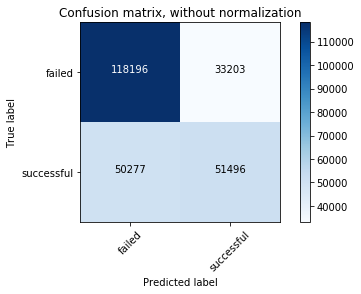

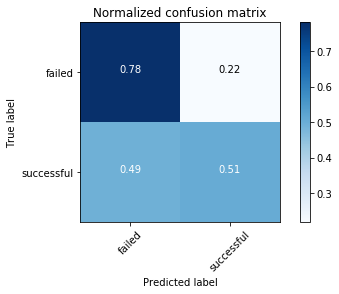

In [72]:
generate_confusion_matrix(expected_results, results, LABELS)

# Kickstarter linear classifier eval

In [73]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05/model/1528280996"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [74]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05",
                            "data","actual_evalset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]

In [75]:
BATCH_SIZE=15
ids=list(df["ID"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(ids):
    feats=list(df[df["ID"]==h].drop(["state"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["ID"]==h]["state"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"kickstarter":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading kickstarter from gs://ml-research-injenia/estimators/trainings-kickstarter/linear-classifier/test05/model/1528280996 to ./tensorflow_model_server_staging/kickstarter
model kickstarter downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/kickstarter
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 20:35:35.978397: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 20:35:35.978447: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: kickstarter

2018-06-07 20:35:36.078948: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: kickstarter version: 1}

2018-06-07 20:35:36.079023: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: kickstarter version: 1}

2018-06-07 20:35:36.079035: I tensorflow_serving/core/load

(489, 1876)
(490, 1876)
(491, 1876)
(492, 1876)
(493, 1876)
(494, 1876)
(495, 1876)
(496, 1876)
(497, 1876)
(498, 1876)
(499, 1876)
(500, 1876)
(501, 1876)
(502, 1876)
(503, 1876)
(504, 1876)
(505, 1876)
(506, 1876)
(507, 1876)
(508, 1876)
(509, 1876)
(510, 1876)
(511, 1876)
(512, 1876)
(513, 1876)
(514, 1876)
(515, 1876)
(516, 1876)
(517, 1876)
(518, 1876)
(519, 1876)
(520, 1876)
(521, 1876)
(522, 1876)
(523, 1876)
(524, 1876)
(525, 1876)
(526, 1876)
(527, 1876)
(528, 1876)
(529, 1876)
(530, 1876)
(531, 1876)
(532, 1876)
(533, 1876)
(534, 1876)
(535, 1876)
(536, 1876)
(537, 1876)
(538, 1876)
(539, 1876)
(540, 1876)
(541, 1876)
(542, 1876)
(543, 1876)
(544, 1876)
(545, 1876)
(546, 1876)
(547, 1876)
(548, 1876)
(549, 1876)
(550, 1876)
(551, 1876)
(552, 1876)
(553, 1876)
(554, 1876)
(555, 1876)
(556, 1876)
(557, 1876)
(558, 1876)
(559, 1876)
(560, 1876)
(561, 1876)
(562, 1876)
(563, 1876)
(564, 1876)
(565, 1876)
(566, 1876)
(567, 1876)
(568, 1876)
(569, 1876)
(570, 1876)
(571, 1876)
(572

(1159, 1876)
(1160, 1876)
(1161, 1876)
(1162, 1876)
(1163, 1876)
(1164, 1876)
(1165, 1876)
(1166, 1876)
(1167, 1876)
(1168, 1876)
(1169, 1876)
(1170, 1876)
(1171, 1876)
(1172, 1876)
(1173, 1876)
(1174, 1876)
(1175, 1876)
(1176, 1876)
(1177, 1876)
(1178, 1876)
(1179, 1876)
(1180, 1876)
(1181, 1876)
(1182, 1876)
(1183, 1876)
(1184, 1876)
(1185, 1876)
(1186, 1876)
(1187, 1876)
(1188, 1876)
(1189, 1876)
(1190, 1876)
(1191, 1876)
(1192, 1876)
(1193, 1876)
(1194, 1876)
(1195, 1876)
(1196, 1876)
(1197, 1876)
(1198, 1876)
(1199, 1876)
(1200, 1876)
(1201, 1876)
(1202, 1876)
(1203, 1876)
(1204, 1876)
(1205, 1876)
(1206, 1876)
(1207, 1876)
(1208, 1876)
(1209, 1876)
(1210, 1876)
(1211, 1876)
(1212, 1876)
(1213, 1876)
(1214, 1876)
(1215, 1876)
(1216, 1876)
(1217, 1876)
(1218, 1876)
(1219, 1876)
(1220, 1876)
(1221, 1876)
(1222, 1876)
(1223, 1876)
(1224, 1876)
(1225, 1876)
(1226, 1876)
(1227, 1876)
(1228, 1876)
(1229, 1876)
(1230, 1876)
(1231, 1876)
(1232, 1876)
(1233, 1876)
(1234, 1876)
(1235, 1876)

(1790, 1876)
(1791, 1876)
(1792, 1876)
(1793, 1876)
(1794, 1876)
(1795, 1876)
(1796, 1876)
(1797, 1876)
(1798, 1876)
(1799, 1876)
(1800, 1876)
(1801, 1876)
(1802, 1876)
(1803, 1876)
(1804, 1876)
(1805, 1876)
(1806, 1876)
(1807, 1876)
(1808, 1876)
(1809, 1876)
(1810, 1876)
(1811, 1876)
(1812, 1876)
(1813, 1876)
(1814, 1876)
(1815, 1876)
(1816, 1876)
(1817, 1876)
(1818, 1876)
(1819, 1876)
(1820, 1876)
(1821, 1876)
(1822, 1876)
(1823, 1876)
(1824, 1876)
(1825, 1876)
(1826, 1876)
(1827, 1876)
(1828, 1876)
(1829, 1876)
(1830, 1876)
(1831, 1876)
(1832, 1876)
(1833, 1876)
(1834, 1876)
(1835, 1876)
(1836, 1876)
(1837, 1876)
(1838, 1876)
(1839, 1876)
(1840, 1876)
(1841, 1876)
(1842, 1876)
(1843, 1876)
(1844, 1876)
(1845, 1876)
(1846, 1876)
(1847, 1876)
(1848, 1876)
(1849, 1876)
(1850, 1876)
(1851, 1876)
(1852, 1876)
(1853, 1876)
(1854, 1876)
(1855, 1876)
(1856, 1876)
(1857, 1876)
(1858, 1876)
(1859, 1876)
(1860, 1876)
(1861, 1876)
(1862, 1876)
(1863, 1876)
(1864, 1876)
(1865, 1876)
(1866, 1876)

Confusion matrix, without normalization
[[13136  3686]
 [ 5622  5686]]
Normalized confusion matrix
[[0.78 0.22]
 [0.5  0.5 ]]


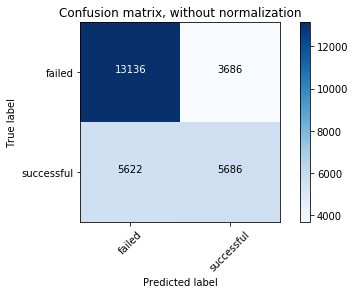

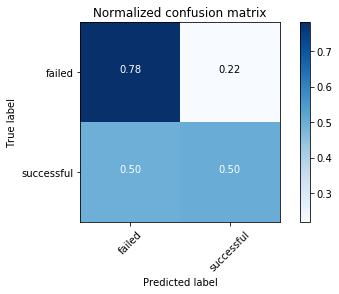

In [76]:
generate_confusion_matrix(expected_results, results, LABELS)

# Kickstarter DNN classifier train

In [77]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02/model/1528279587"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [78]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02",
                            "data","actual_trainset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]

In [79]:
BATCH_SIZE=15
ids=list(df["ID"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(ids):
    feats=list(df[df["ID"]==h].drop(["state"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["ID"]==h]["state"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"kickstarter":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading kickstarter from gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02/model/1528279587 to ./tensorflow_model_server_staging/kickstarter
model kickstarter downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/kickstarter
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-07 21:32:20.008810: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-07 21:32:20.008866: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: kickstarter

2018-06-07 21:32:20.109374: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: kickstarter version: 1}

2018-06-07 21:32:20.109415: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: kickstarter version: 1}

2018-06-07 21:32:20.109425: I tensorflow_serving/core/loader_

(452, 16879)
(453, 16879)
(454, 16879)
(455, 16879)
(456, 16879)
(457, 16879)
(458, 16879)
(459, 16879)
(460, 16879)
(461, 16879)
(462, 16879)
(463, 16879)
(464, 16879)
(465, 16879)
(466, 16879)
(467, 16879)
(468, 16879)
(469, 16879)
(470, 16879)
(471, 16879)
(472, 16879)
(473, 16879)
(474, 16879)
(475, 16879)
(476, 16879)
(477, 16879)
(478, 16879)
(479, 16879)
(480, 16879)
(481, 16879)
(482, 16879)
(483, 16879)
(484, 16879)
(485, 16879)
(486, 16879)
(487, 16879)
(488, 16879)
(489, 16879)
(490, 16879)
(491, 16879)
(492, 16879)
(493, 16879)
(494, 16879)
(495, 16879)
(496, 16879)
(497, 16879)
(498, 16879)
(499, 16879)
(500, 16879)
(501, 16879)
(502, 16879)
(503, 16879)
(504, 16879)
(505, 16879)
(506, 16879)
(507, 16879)
(508, 16879)
(509, 16879)
(510, 16879)
(511, 16879)
(512, 16879)
(513, 16879)
(514, 16879)
(515, 16879)
(516, 16879)
(517, 16879)
(518, 16879)
(519, 16879)
(520, 16879)
(521, 16879)
(522, 16879)
(523, 16879)
(524, 16879)
(525, 16879)
(526, 16879)
(527, 16879)
(528, 16879)

(1077, 16879)
(1078, 16879)
(1079, 16879)
(1080, 16879)
(1081, 16879)
(1082, 16879)
(1083, 16879)
(1084, 16879)
(1085, 16879)
(1086, 16879)
(1087, 16879)
(1088, 16879)
(1089, 16879)
(1090, 16879)
(1091, 16879)
(1092, 16879)
(1093, 16879)
(1094, 16879)
(1095, 16879)
(1096, 16879)
(1097, 16879)
(1098, 16879)
(1099, 16879)
(1100, 16879)
(1101, 16879)
(1102, 16879)
(1103, 16879)
(1104, 16879)
(1105, 16879)
(1106, 16879)
(1107, 16879)
(1108, 16879)
(1109, 16879)
(1110, 16879)
(1111, 16879)
(1112, 16879)
(1113, 16879)
(1114, 16879)
(1115, 16879)
(1116, 16879)
(1117, 16879)
(1118, 16879)
(1119, 16879)
(1120, 16879)
(1121, 16879)
(1122, 16879)
(1123, 16879)
(1124, 16879)
(1125, 16879)
(1126, 16879)
(1127, 16879)
(1128, 16879)
(1129, 16879)
(1130, 16879)
(1131, 16879)
(1132, 16879)
(1133, 16879)
(1134, 16879)
(1135, 16879)
(1136, 16879)
(1137, 16879)
(1138, 16879)
(1139, 16879)
(1140, 16879)
(1141, 16879)
(1142, 16879)
(1143, 16879)
(1144, 16879)
(1145, 16879)
(1146, 16879)
(1147, 16879)
(1148,

(1663, 16879)
(1664, 16879)
(1665, 16879)
(1666, 16879)
(1667, 16879)
(1668, 16879)
(1669, 16879)
(1670, 16879)
(1671, 16879)
(1672, 16879)
(1673, 16879)
(1674, 16879)
(1675, 16879)
(1676, 16879)
(1677, 16879)
(1678, 16879)
(1679, 16879)
(1680, 16879)
(1681, 16879)
(1682, 16879)
(1683, 16879)
(1684, 16879)
(1685, 16879)
(1686, 16879)
(1687, 16879)
(1688, 16879)
(1689, 16879)
(1690, 16879)
(1691, 16879)
(1692, 16879)
(1693, 16879)
(1694, 16879)
(1695, 16879)
(1696, 16879)
(1697, 16879)
(1698, 16879)
(1699, 16879)
(1700, 16879)
(1701, 16879)
(1702, 16879)
(1703, 16879)
(1704, 16879)
(1705, 16879)
(1706, 16879)
(1707, 16879)
(1708, 16879)
(1709, 16879)
(1710, 16879)
(1711, 16879)
(1712, 16879)
(1713, 16879)
(1714, 16879)
(1715, 16879)
(1716, 16879)
(1717, 16879)
(1718, 16879)
(1719, 16879)
(1720, 16879)
(1721, 16879)
(1722, 16879)
(1723, 16879)
(1724, 16879)
(1725, 16879)
(1726, 16879)
(1727, 16879)
(1728, 16879)
(1729, 16879)
(1730, 16879)
(1731, 16879)
(1732, 16879)
(1733, 16879)
(1734,

(2249, 16879)
(2250, 16879)
(2251, 16879)
(2252, 16879)
(2253, 16879)
(2254, 16879)
(2255, 16879)
(2256, 16879)
(2257, 16879)
(2258, 16879)
(2259, 16879)
(2260, 16879)
(2261, 16879)
(2262, 16879)
(2263, 16879)
(2264, 16879)
(2265, 16879)
(2266, 16879)
(2267, 16879)
(2268, 16879)
(2269, 16879)
(2270, 16879)
(2271, 16879)
(2272, 16879)
(2273, 16879)
(2274, 16879)
(2275, 16879)
(2276, 16879)
(2277, 16879)
(2278, 16879)
(2279, 16879)
(2280, 16879)
(2281, 16879)
(2282, 16879)
(2283, 16879)
(2284, 16879)
(2285, 16879)
(2286, 16879)
(2287, 16879)
(2288, 16879)
(2289, 16879)
(2290, 16879)
(2291, 16879)
(2292, 16879)
(2293, 16879)
(2294, 16879)
(2295, 16879)
(2296, 16879)
(2297, 16879)
(2298, 16879)
(2299, 16879)
(2300, 16879)
(2301, 16879)
(2302, 16879)
(2303, 16879)
(2304, 16879)
(2305, 16879)
(2306, 16879)
(2307, 16879)
(2308, 16879)
(2309, 16879)
(2310, 16879)
(2311, 16879)
(2312, 16879)
(2313, 16879)
(2314, 16879)
(2315, 16879)
(2316, 16879)
(2317, 16879)
(2318, 16879)
(2319, 16879)
(2320,

(2835, 16879)
(2836, 16879)
(2837, 16879)
(2838, 16879)
(2839, 16879)
(2840, 16879)
(2841, 16879)
(2842, 16879)
(2843, 16879)
(2844, 16879)
(2845, 16879)
(2846, 16879)
(2847, 16879)
(2848, 16879)
(2849, 16879)
(2850, 16879)
(2851, 16879)
(2852, 16879)
(2853, 16879)
(2854, 16879)
(2855, 16879)
(2856, 16879)
(2857, 16879)
(2858, 16879)
(2859, 16879)
(2860, 16879)
(2861, 16879)
(2862, 16879)
(2863, 16879)
(2864, 16879)
(2865, 16879)
(2866, 16879)
(2867, 16879)
(2868, 16879)
(2869, 16879)
(2870, 16879)
(2871, 16879)
(2872, 16879)
(2873, 16879)
(2874, 16879)
(2875, 16879)
(2876, 16879)
(2877, 16879)
(2878, 16879)
(2879, 16879)
(2880, 16879)
(2881, 16879)
(2882, 16879)
(2883, 16879)
(2884, 16879)
(2885, 16879)
(2886, 16879)
(2887, 16879)
(2888, 16879)
(2889, 16879)
(2890, 16879)
(2891, 16879)
(2892, 16879)
(2893, 16879)
(2894, 16879)
(2895, 16879)
(2896, 16879)
(2897, 16879)
(2898, 16879)
(2899, 16879)
(2900, 16879)
(2901, 16879)
(2902, 16879)
(2903, 16879)
(2904, 16879)
(2905, 16879)
(2906,

(3421, 16879)
(3422, 16879)
(3423, 16879)
(3424, 16879)
(3425, 16879)
(3426, 16879)
(3427, 16879)
(3428, 16879)
(3429, 16879)
(3430, 16879)
(3431, 16879)
(3432, 16879)
(3433, 16879)
(3434, 16879)
(3435, 16879)
(3436, 16879)
(3437, 16879)
(3438, 16879)
(3439, 16879)
(3440, 16879)
(3441, 16879)
(3442, 16879)
(3443, 16879)
(3444, 16879)
(3445, 16879)
(3446, 16879)
(3447, 16879)
(3448, 16879)
(3449, 16879)
(3450, 16879)
(3451, 16879)
(3452, 16879)
(3453, 16879)
(3454, 16879)
(3455, 16879)
(3456, 16879)
(3457, 16879)
(3458, 16879)
(3459, 16879)
(3460, 16879)
(3461, 16879)
(3462, 16879)
(3463, 16879)
(3464, 16879)
(3465, 16879)
(3466, 16879)
(3467, 16879)
(3468, 16879)
(3469, 16879)
(3470, 16879)
(3471, 16879)
(3472, 16879)
(3473, 16879)
(3474, 16879)
(3475, 16879)
(3476, 16879)
(3477, 16879)
(3478, 16879)
(3479, 16879)
(3480, 16879)
(3481, 16879)
(3482, 16879)
(3483, 16879)
(3484, 16879)
(3485, 16879)
(3486, 16879)
(3487, 16879)
(3488, 16879)
(3489, 16879)
(3490, 16879)
(3491, 16879)
(3492,

(4007, 16879)
(4008, 16879)
(4009, 16879)
(4010, 16879)
(4011, 16879)
(4012, 16879)
(4013, 16879)
(4014, 16879)
(4015, 16879)
(4016, 16879)
(4017, 16879)
(4018, 16879)
(4019, 16879)
(4020, 16879)
(4021, 16879)
(4022, 16879)
(4023, 16879)
(4024, 16879)
(4025, 16879)
(4026, 16879)
(4027, 16879)
(4028, 16879)
(4029, 16879)
(4030, 16879)
(4031, 16879)
(4032, 16879)
(4033, 16879)
(4034, 16879)
(4035, 16879)
(4036, 16879)
(4037, 16879)
(4038, 16879)
(4039, 16879)
(4040, 16879)
(4041, 16879)
(4042, 16879)
(4043, 16879)
(4044, 16879)
(4045, 16879)
(4046, 16879)
(4047, 16879)
(4048, 16879)
(4049, 16879)
(4050, 16879)
(4051, 16879)
(4052, 16879)
(4053, 16879)
(4054, 16879)
(4055, 16879)
(4056, 16879)
(4057, 16879)
(4058, 16879)
(4059, 16879)
(4060, 16879)
(4061, 16879)
(4062, 16879)
(4063, 16879)
(4064, 16879)
(4065, 16879)
(4066, 16879)
(4067, 16879)
(4068, 16879)
(4069, 16879)
(4070, 16879)
(4071, 16879)
(4072, 16879)
(4073, 16879)
(4074, 16879)
(4075, 16879)
(4076, 16879)
(4077, 16879)
(4078,

(4593, 16879)
(4594, 16879)
(4595, 16879)
(4596, 16879)
(4597, 16879)
(4598, 16879)
(4599, 16879)
(4600, 16879)
(4601, 16879)
(4602, 16879)
(4603, 16879)
(4604, 16879)
(4605, 16879)
(4606, 16879)
(4607, 16879)
(4608, 16879)
(4609, 16879)
(4610, 16879)
(4611, 16879)
(4612, 16879)
(4613, 16879)
(4614, 16879)
(4615, 16879)
(4616, 16879)
(4617, 16879)
(4618, 16879)
(4619, 16879)
(4620, 16879)
(4621, 16879)
(4622, 16879)
(4623, 16879)
(4624, 16879)
(4625, 16879)
(4626, 16879)
(4627, 16879)
(4628, 16879)
(4629, 16879)
(4630, 16879)
(4631, 16879)
(4632, 16879)
(4633, 16879)
(4634, 16879)
(4635, 16879)
(4636, 16879)
(4637, 16879)
(4638, 16879)
(4639, 16879)
(4640, 16879)
(4641, 16879)
(4642, 16879)
(4643, 16879)
(4644, 16879)
(4645, 16879)
(4646, 16879)
(4647, 16879)
(4648, 16879)
(4649, 16879)
(4650, 16879)
(4651, 16879)
(4652, 16879)
(4653, 16879)
(4654, 16879)
(4655, 16879)
(4656, 16879)
(4657, 16879)
(4658, 16879)
(4659, 16879)
(4660, 16879)
(4661, 16879)
(4662, 16879)
(4663, 16879)
(4664,

(5179, 16879)
(5180, 16879)
(5181, 16879)
(5182, 16879)
(5183, 16879)
(5184, 16879)
(5185, 16879)
(5186, 16879)
(5187, 16879)
(5188, 16879)
(5189, 16879)
(5190, 16879)
(5191, 16879)
(5192, 16879)
(5193, 16879)
(5194, 16879)
(5195, 16879)
(5196, 16879)
(5197, 16879)
(5198, 16879)
(5199, 16879)
(5200, 16879)
(5201, 16879)
(5202, 16879)
(5203, 16879)
(5204, 16879)
(5205, 16879)
(5206, 16879)
(5207, 16879)
(5208, 16879)
(5209, 16879)
(5210, 16879)
(5211, 16879)
(5212, 16879)
(5213, 16879)
(5214, 16879)
(5215, 16879)
(5216, 16879)
(5217, 16879)
(5218, 16879)
(5219, 16879)
(5220, 16879)
(5221, 16879)
(5222, 16879)
(5223, 16879)
(5224, 16879)
(5225, 16879)
(5226, 16879)
(5227, 16879)
(5228, 16879)
(5229, 16879)
(5230, 16879)
(5231, 16879)
(5232, 16879)
(5233, 16879)
(5234, 16879)
(5235, 16879)
(5236, 16879)
(5237, 16879)
(5238, 16879)
(5239, 16879)
(5240, 16879)
(5241, 16879)
(5242, 16879)
(5243, 16879)
(5244, 16879)
(5245, 16879)
(5246, 16879)
(5247, 16879)
(5248, 16879)
(5249, 16879)
(5250,

(5765, 16879)
(5766, 16879)
(5767, 16879)
(5768, 16879)
(5769, 16879)
(5770, 16879)
(5771, 16879)
(5772, 16879)
(5773, 16879)
(5774, 16879)
(5775, 16879)
(5776, 16879)
(5777, 16879)
(5778, 16879)
(5779, 16879)
(5780, 16879)
(5781, 16879)
(5782, 16879)
(5783, 16879)
(5784, 16879)
(5785, 16879)
(5786, 16879)
(5787, 16879)
(5788, 16879)
(5789, 16879)
(5790, 16879)
(5791, 16879)
(5792, 16879)
(5793, 16879)
(5794, 16879)
(5795, 16879)
(5796, 16879)
(5797, 16879)
(5798, 16879)
(5799, 16879)
(5800, 16879)
(5801, 16879)
(5802, 16879)
(5803, 16879)
(5804, 16879)
(5805, 16879)
(5806, 16879)
(5807, 16879)
(5808, 16879)
(5809, 16879)
(5810, 16879)
(5811, 16879)
(5812, 16879)
(5813, 16879)
(5814, 16879)
(5815, 16879)
(5816, 16879)
(5817, 16879)
(5818, 16879)
(5819, 16879)
(5820, 16879)
(5821, 16879)
(5822, 16879)
(5823, 16879)
(5824, 16879)
(5825, 16879)
(5826, 16879)
(5827, 16879)
(5828, 16879)
(5829, 16879)
(5830, 16879)
(5831, 16879)
(5832, 16879)
(5833, 16879)
(5834, 16879)
(5835, 16879)
(5836,

(6351, 16879)
(6352, 16879)
(6353, 16879)
(6354, 16879)
(6355, 16879)
(6356, 16879)
(6357, 16879)
(6358, 16879)
(6359, 16879)
(6360, 16879)
(6361, 16879)
(6362, 16879)
(6363, 16879)
(6364, 16879)
(6365, 16879)
(6366, 16879)
(6367, 16879)
(6368, 16879)
(6369, 16879)
(6370, 16879)
(6371, 16879)
(6372, 16879)
(6373, 16879)
(6374, 16879)
(6375, 16879)
(6376, 16879)
(6377, 16879)
(6378, 16879)
(6379, 16879)
(6380, 16879)
(6381, 16879)
(6382, 16879)
(6383, 16879)
(6384, 16879)
(6385, 16879)
(6386, 16879)
(6387, 16879)
(6388, 16879)
(6389, 16879)
(6390, 16879)
(6391, 16879)
(6392, 16879)
(6393, 16879)
(6394, 16879)
(6395, 16879)
(6396, 16879)
(6397, 16879)
(6398, 16879)
(6399, 16879)
(6400, 16879)
(6401, 16879)
(6402, 16879)
(6403, 16879)
(6404, 16879)
(6405, 16879)
(6406, 16879)
(6407, 16879)
(6408, 16879)
(6409, 16879)
(6410, 16879)
(6411, 16879)
(6412, 16879)
(6413, 16879)
(6414, 16879)
(6415, 16879)
(6416, 16879)
(6417, 16879)
(6418, 16879)
(6419, 16879)
(6420, 16879)
(6421, 16879)
(6422,

(6937, 16879)
(6938, 16879)
(6939, 16879)
(6940, 16879)
(6941, 16879)
(6942, 16879)
(6943, 16879)
(6944, 16879)
(6945, 16879)
(6946, 16879)
(6947, 16879)
(6948, 16879)
(6949, 16879)
(6950, 16879)
(6951, 16879)
(6952, 16879)
(6953, 16879)
(6954, 16879)
(6955, 16879)
(6956, 16879)
(6957, 16879)
(6958, 16879)
(6959, 16879)
(6960, 16879)
(6961, 16879)
(6962, 16879)
(6963, 16879)
(6964, 16879)
(6965, 16879)
(6966, 16879)
(6967, 16879)
(6968, 16879)
(6969, 16879)
(6970, 16879)
(6971, 16879)
(6972, 16879)
(6973, 16879)
(6974, 16879)
(6975, 16879)
(6976, 16879)
(6977, 16879)
(6978, 16879)
(6979, 16879)
(6980, 16879)
(6981, 16879)
(6982, 16879)
(6983, 16879)
(6984, 16879)
(6985, 16879)
(6986, 16879)
(6987, 16879)
(6988, 16879)
(6989, 16879)
(6990, 16879)
(6991, 16879)
(6992, 16879)
(6993, 16879)
(6994, 16879)
(6995, 16879)
(6996, 16879)
(6997, 16879)
(6998, 16879)
(6999, 16879)
(7000, 16879)
(7001, 16879)
(7002, 16879)
(7003, 16879)
(7004, 16879)
(7005, 16879)
(7006, 16879)
(7007, 16879)
(7008,

(7523, 16879)
(7524, 16879)
(7525, 16879)
(7526, 16879)
(7527, 16879)
(7528, 16879)
(7529, 16879)
(7530, 16879)
(7531, 16879)
(7532, 16879)
(7533, 16879)
(7534, 16879)
(7535, 16879)
(7536, 16879)
(7537, 16879)
(7538, 16879)
(7539, 16879)
(7540, 16879)
(7541, 16879)
(7542, 16879)
(7543, 16879)
(7544, 16879)
(7545, 16879)
(7546, 16879)
(7547, 16879)
(7548, 16879)
(7549, 16879)
(7550, 16879)
(7551, 16879)
(7552, 16879)
(7553, 16879)
(7554, 16879)
(7555, 16879)
(7556, 16879)
(7557, 16879)
(7558, 16879)
(7559, 16879)
(7560, 16879)
(7561, 16879)
(7562, 16879)
(7563, 16879)
(7564, 16879)
(7565, 16879)
(7566, 16879)
(7567, 16879)
(7568, 16879)
(7569, 16879)
(7570, 16879)
(7571, 16879)
(7572, 16879)
(7573, 16879)
(7574, 16879)
(7575, 16879)
(7576, 16879)
(7577, 16879)
(7578, 16879)
(7579, 16879)
(7580, 16879)
(7581, 16879)
(7582, 16879)
(7583, 16879)
(7584, 16879)
(7585, 16879)
(7586, 16879)
(7587, 16879)
(7588, 16879)
(7589, 16879)
(7590, 16879)
(7591, 16879)
(7592, 16879)
(7593, 16879)
(7594,

(8109, 16879)
(8110, 16879)
(8111, 16879)
(8112, 16879)
(8113, 16879)
(8114, 16879)
(8115, 16879)
(8116, 16879)
(8117, 16879)
(8118, 16879)
(8119, 16879)
(8120, 16879)
(8121, 16879)
(8122, 16879)
(8123, 16879)
(8124, 16879)
(8125, 16879)
(8126, 16879)
(8127, 16879)
(8128, 16879)
(8129, 16879)
(8130, 16879)
(8131, 16879)
(8132, 16879)
(8133, 16879)
(8134, 16879)
(8135, 16879)
(8136, 16879)
(8137, 16879)
(8138, 16879)
(8139, 16879)
(8140, 16879)
(8141, 16879)
(8142, 16879)
(8143, 16879)
(8144, 16879)
(8145, 16879)
(8146, 16879)
(8147, 16879)
(8148, 16879)
(8149, 16879)
(8150, 16879)
(8151, 16879)
(8152, 16879)
(8153, 16879)
(8154, 16879)
(8155, 16879)
(8156, 16879)
(8157, 16879)
(8158, 16879)
(8159, 16879)
(8160, 16879)
(8161, 16879)
(8162, 16879)
(8163, 16879)
(8164, 16879)
(8165, 16879)
(8166, 16879)
(8167, 16879)
(8168, 16879)
(8169, 16879)
(8170, 16879)
(8171, 16879)
(8172, 16879)
(8173, 16879)
(8174, 16879)
(8175, 16879)
(8176, 16879)
(8177, 16879)
(8178, 16879)
(8179, 16879)
(8180,

(8695, 16879)
(8696, 16879)
(8697, 16879)
(8698, 16879)
(8699, 16879)
(8700, 16879)
(8701, 16879)
(8702, 16879)
(8703, 16879)
(8704, 16879)
(8705, 16879)
(8706, 16879)
(8707, 16879)
(8708, 16879)
(8709, 16879)
(8710, 16879)
(8711, 16879)
(8712, 16879)
(8713, 16879)
(8714, 16879)
(8715, 16879)
(8716, 16879)
(8717, 16879)
(8718, 16879)
(8719, 16879)
(8720, 16879)
(8721, 16879)
(8722, 16879)
(8723, 16879)
(8724, 16879)
(8725, 16879)
(8726, 16879)
(8727, 16879)
(8728, 16879)
(8729, 16879)
(8730, 16879)
(8731, 16879)
(8732, 16879)
(8733, 16879)
(8734, 16879)
(8735, 16879)
(8736, 16879)
(8737, 16879)
(8738, 16879)
(8739, 16879)
(8740, 16879)
(8741, 16879)
(8742, 16879)
(8743, 16879)
(8744, 16879)
(8745, 16879)
(8746, 16879)
(8747, 16879)
(8748, 16879)
(8749, 16879)
(8750, 16879)
(8751, 16879)
(8752, 16879)
(8753, 16879)
(8754, 16879)
(8755, 16879)
(8756, 16879)
(8757, 16879)
(8758, 16879)
(8759, 16879)
(8760, 16879)
(8761, 16879)
(8762, 16879)
(8763, 16879)
(8764, 16879)
(8765, 16879)
(8766,

(9281, 16879)
(9282, 16879)
(9283, 16879)
(9284, 16879)
(9285, 16879)
(9286, 16879)
(9287, 16879)
(9288, 16879)
(9289, 16879)
(9290, 16879)
(9291, 16879)
(9292, 16879)
(9293, 16879)
(9294, 16879)
(9295, 16879)
(9296, 16879)
(9297, 16879)
(9298, 16879)
(9299, 16879)
(9300, 16879)
(9301, 16879)
(9302, 16879)
(9303, 16879)
(9304, 16879)
(9305, 16879)
(9306, 16879)
(9307, 16879)
(9308, 16879)
(9309, 16879)
(9310, 16879)
(9311, 16879)
(9312, 16879)
(9313, 16879)
(9314, 16879)
(9315, 16879)
(9316, 16879)
(9317, 16879)
(9318, 16879)
(9319, 16879)
(9320, 16879)
(9321, 16879)
(9322, 16879)
(9323, 16879)
(9324, 16879)
(9325, 16879)
(9326, 16879)
(9327, 16879)
(9328, 16879)
(9329, 16879)
(9330, 16879)
(9331, 16879)
(9332, 16879)
(9333, 16879)
(9334, 16879)
(9335, 16879)
(9336, 16879)
(9337, 16879)
(9338, 16879)
(9339, 16879)
(9340, 16879)
(9341, 16879)
(9342, 16879)
(9343, 16879)
(9344, 16879)
(9345, 16879)
(9346, 16879)
(9347, 16879)
(9348, 16879)
(9349, 16879)
(9350, 16879)
(9351, 16879)
(9352,

(9867, 16879)
(9868, 16879)
(9869, 16879)
(9870, 16879)
(9871, 16879)
(9872, 16879)
(9873, 16879)
(9874, 16879)
(9875, 16879)
(9876, 16879)
(9877, 16879)
(9878, 16879)
(9879, 16879)
(9880, 16879)
(9881, 16879)
(9882, 16879)
(9883, 16879)
(9884, 16879)
(9885, 16879)
(9886, 16879)
(9887, 16879)
(9888, 16879)
(9889, 16879)
(9890, 16879)
(9891, 16879)
(9892, 16879)
(9893, 16879)
(9894, 16879)
(9895, 16879)
(9896, 16879)
(9897, 16879)
(9898, 16879)
(9899, 16879)
(9900, 16879)
(9901, 16879)
(9902, 16879)
(9903, 16879)
(9904, 16879)
(9905, 16879)
(9906, 16879)
(9907, 16879)
(9908, 16879)
(9909, 16879)
(9910, 16879)
(9911, 16879)
(9912, 16879)
(9913, 16879)
(9914, 16879)
(9915, 16879)
(9916, 16879)
(9917, 16879)
(9918, 16879)
(9919, 16879)
(9920, 16879)
(9921, 16879)
(9922, 16879)
(9923, 16879)
(9924, 16879)
(9925, 16879)
(9926, 16879)
(9927, 16879)
(9928, 16879)
(9929, 16879)
(9930, 16879)
(9931, 16879)
(9932, 16879)
(9933, 16879)
(9934, 16879)
(9935, 16879)
(9936, 16879)
(9937, 16879)
(9938,

(10423, 16879)
(10424, 16879)
(10425, 16879)
(10426, 16879)
(10427, 16879)
(10428, 16879)
(10429, 16879)
(10430, 16879)
(10431, 16879)
(10432, 16879)
(10433, 16879)
(10434, 16879)
(10435, 16879)
(10436, 16879)
(10437, 16879)
(10438, 16879)
(10439, 16879)
(10440, 16879)
(10441, 16879)
(10442, 16879)
(10443, 16879)
(10444, 16879)
(10445, 16879)
(10446, 16879)
(10447, 16879)
(10448, 16879)
(10449, 16879)
(10450, 16879)
(10451, 16879)
(10452, 16879)
(10453, 16879)
(10454, 16879)
(10455, 16879)
(10456, 16879)
(10457, 16879)
(10458, 16879)
(10459, 16879)
(10460, 16879)
(10461, 16879)
(10462, 16879)
(10463, 16879)
(10464, 16879)
(10465, 16879)
(10466, 16879)
(10467, 16879)
(10468, 16879)
(10469, 16879)
(10470, 16879)
(10471, 16879)
(10472, 16879)
(10473, 16879)
(10474, 16879)
(10475, 16879)
(10476, 16879)
(10477, 16879)
(10478, 16879)
(10479, 16879)
(10480, 16879)
(10481, 16879)
(10482, 16879)
(10483, 16879)
(10484, 16879)
(10485, 16879)
(10486, 16879)
(10487, 16879)
(10488, 16879)
(10489, 16

(10970, 16879)
(10971, 16879)
(10972, 16879)
(10973, 16879)
(10974, 16879)
(10975, 16879)
(10976, 16879)
(10977, 16879)
(10978, 16879)
(10979, 16879)
(10980, 16879)
(10981, 16879)
(10982, 16879)
(10983, 16879)
(10984, 16879)
(10985, 16879)
(10986, 16879)
(10987, 16879)
(10988, 16879)
(10989, 16879)
(10990, 16879)
(10991, 16879)
(10992, 16879)
(10993, 16879)
(10994, 16879)
(10995, 16879)
(10996, 16879)
(10997, 16879)
(10998, 16879)
(10999, 16879)
(11000, 16879)
(11001, 16879)
(11002, 16879)
(11003, 16879)
(11004, 16879)
(11005, 16879)
(11006, 16879)
(11007, 16879)
(11008, 16879)
(11009, 16879)
(11010, 16879)
(11011, 16879)
(11012, 16879)
(11013, 16879)
(11014, 16879)
(11015, 16879)
(11016, 16879)
(11017, 16879)
(11018, 16879)
(11019, 16879)
(11020, 16879)
(11021, 16879)
(11022, 16879)
(11023, 16879)
(11024, 16879)
(11025, 16879)
(11026, 16879)
(11027, 16879)
(11028, 16879)
(11029, 16879)
(11030, 16879)
(11031, 16879)
(11032, 16879)
(11033, 16879)
(11034, 16879)
(11035, 16879)
(11036, 16

(11517, 16879)
(11518, 16879)
(11519, 16879)
(11520, 16879)
(11521, 16879)
(11522, 16879)
(11523, 16879)
(11524, 16879)
(11525, 16879)
(11526, 16879)
(11527, 16879)
(11528, 16879)
(11529, 16879)
(11530, 16879)
(11531, 16879)
(11532, 16879)
(11533, 16879)
(11534, 16879)
(11535, 16879)
(11536, 16879)
(11537, 16879)
(11538, 16879)
(11539, 16879)
(11540, 16879)
(11541, 16879)
(11542, 16879)
(11543, 16879)
(11544, 16879)
(11545, 16879)
(11546, 16879)
(11547, 16879)
(11548, 16879)
(11549, 16879)
(11550, 16879)
(11551, 16879)
(11552, 16879)
(11553, 16879)
(11554, 16879)
(11555, 16879)
(11556, 16879)
(11557, 16879)
(11558, 16879)
(11559, 16879)
(11560, 16879)
(11561, 16879)
(11562, 16879)
(11563, 16879)
(11564, 16879)
(11565, 16879)
(11566, 16879)
(11567, 16879)
(11568, 16879)
(11569, 16879)
(11570, 16879)
(11571, 16879)
(11572, 16879)
(11573, 16879)
(11574, 16879)
(11575, 16879)
(11576, 16879)
(11577, 16879)
(11578, 16879)
(11579, 16879)
(11580, 16879)
(11581, 16879)
(11582, 16879)
(11583, 16

(12064, 16879)
(12065, 16879)
(12066, 16879)
(12067, 16879)
(12068, 16879)
(12069, 16879)
(12070, 16879)
(12071, 16879)
(12072, 16879)
(12073, 16879)
(12074, 16879)
(12075, 16879)
(12076, 16879)
(12077, 16879)
(12078, 16879)
(12079, 16879)
(12080, 16879)
(12081, 16879)
(12082, 16879)
(12083, 16879)
(12084, 16879)
(12085, 16879)
(12086, 16879)
(12087, 16879)
(12088, 16879)
(12089, 16879)
(12090, 16879)
(12091, 16879)
(12092, 16879)
(12093, 16879)
(12094, 16879)
(12095, 16879)
(12096, 16879)
(12097, 16879)
(12098, 16879)
(12099, 16879)
(12100, 16879)
(12101, 16879)
(12102, 16879)
(12103, 16879)
(12104, 16879)
(12105, 16879)
(12106, 16879)
(12107, 16879)
(12108, 16879)
(12109, 16879)
(12110, 16879)
(12111, 16879)
(12112, 16879)
(12113, 16879)
(12114, 16879)
(12115, 16879)
(12116, 16879)
(12117, 16879)
(12118, 16879)
(12119, 16879)
(12120, 16879)
(12121, 16879)
(12122, 16879)
(12123, 16879)
(12124, 16879)
(12125, 16879)
(12126, 16879)
(12127, 16879)
(12128, 16879)
(12129, 16879)
(12130, 16

(12611, 16879)
(12612, 16879)
(12613, 16879)
(12614, 16879)
(12615, 16879)
(12616, 16879)
(12617, 16879)
(12618, 16879)
(12619, 16879)
(12620, 16879)
(12621, 16879)
(12622, 16879)
(12623, 16879)
(12624, 16879)
(12625, 16879)
(12626, 16879)
(12627, 16879)
(12628, 16879)
(12629, 16879)
(12630, 16879)
(12631, 16879)
(12632, 16879)
(12633, 16879)
(12634, 16879)
(12635, 16879)
(12636, 16879)
(12637, 16879)
(12638, 16879)
(12639, 16879)
(12640, 16879)
(12641, 16879)
(12642, 16879)
(12643, 16879)
(12644, 16879)
(12645, 16879)
(12646, 16879)
(12647, 16879)
(12648, 16879)
(12649, 16879)
(12650, 16879)
(12651, 16879)
(12652, 16879)
(12653, 16879)
(12654, 16879)
(12655, 16879)
(12656, 16879)
(12657, 16879)
(12658, 16879)
(12659, 16879)
(12660, 16879)
(12661, 16879)
(12662, 16879)
(12663, 16879)
(12664, 16879)
(12665, 16879)
(12666, 16879)
(12667, 16879)
(12668, 16879)
(12669, 16879)
(12670, 16879)
(12671, 16879)
(12672, 16879)
(12673, 16879)
(12674, 16879)
(12675, 16879)
(12676, 16879)
(12677, 16

(13158, 16879)
(13159, 16879)
(13160, 16879)
(13161, 16879)
(13162, 16879)
(13163, 16879)
(13164, 16879)
(13165, 16879)
(13166, 16879)
(13167, 16879)
(13168, 16879)
(13169, 16879)
(13170, 16879)
(13171, 16879)
(13172, 16879)
(13173, 16879)
(13174, 16879)
(13175, 16879)
(13176, 16879)
(13177, 16879)
(13178, 16879)
(13179, 16879)
(13180, 16879)
(13181, 16879)
(13182, 16879)
(13183, 16879)
(13184, 16879)
(13185, 16879)
(13186, 16879)
(13187, 16879)
(13188, 16879)
(13189, 16879)
(13190, 16879)
(13191, 16879)
(13192, 16879)
(13193, 16879)
(13194, 16879)
(13195, 16879)
(13196, 16879)
(13197, 16879)
(13198, 16879)
(13199, 16879)
(13200, 16879)
(13201, 16879)
(13202, 16879)
(13203, 16879)
(13204, 16879)
(13205, 16879)
(13206, 16879)
(13207, 16879)
(13208, 16879)
(13209, 16879)
(13210, 16879)
(13211, 16879)
(13212, 16879)
(13213, 16879)
(13214, 16879)
(13215, 16879)
(13216, 16879)
(13217, 16879)
(13218, 16879)
(13219, 16879)
(13220, 16879)
(13221, 16879)
(13222, 16879)
(13223, 16879)
(13224, 16

(13705, 16879)
(13706, 16879)
(13707, 16879)
(13708, 16879)
(13709, 16879)
(13710, 16879)
(13711, 16879)
(13712, 16879)
(13713, 16879)
(13714, 16879)
(13715, 16879)
(13716, 16879)
(13717, 16879)
(13718, 16879)
(13719, 16879)
(13720, 16879)
(13721, 16879)
(13722, 16879)
(13723, 16879)
(13724, 16879)
(13725, 16879)
(13726, 16879)
(13727, 16879)
(13728, 16879)
(13729, 16879)
(13730, 16879)
(13731, 16879)
(13732, 16879)
(13733, 16879)
(13734, 16879)
(13735, 16879)
(13736, 16879)
(13737, 16879)
(13738, 16879)
(13739, 16879)
(13740, 16879)
(13741, 16879)
(13742, 16879)
(13743, 16879)
(13744, 16879)
(13745, 16879)
(13746, 16879)
(13747, 16879)
(13748, 16879)
(13749, 16879)
(13750, 16879)
(13751, 16879)
(13752, 16879)
(13753, 16879)
(13754, 16879)
(13755, 16879)
(13756, 16879)
(13757, 16879)
(13758, 16879)
(13759, 16879)
(13760, 16879)
(13761, 16879)
(13762, 16879)
(13763, 16879)
(13764, 16879)
(13765, 16879)
(13766, 16879)
(13767, 16879)
(13768, 16879)
(13769, 16879)
(13770, 16879)
(13771, 16

(14252, 16879)
(14253, 16879)
(14254, 16879)
(14255, 16879)
(14256, 16879)
(14257, 16879)
(14258, 16879)
(14259, 16879)
(14260, 16879)
(14261, 16879)
(14262, 16879)
(14263, 16879)
(14264, 16879)
(14265, 16879)
(14266, 16879)
(14267, 16879)
(14268, 16879)
(14269, 16879)
(14270, 16879)
(14271, 16879)
(14272, 16879)
(14273, 16879)
(14274, 16879)
(14275, 16879)
(14276, 16879)
(14277, 16879)
(14278, 16879)
(14279, 16879)
(14280, 16879)
(14281, 16879)
(14282, 16879)
(14283, 16879)
(14284, 16879)
(14285, 16879)
(14286, 16879)
(14287, 16879)
(14288, 16879)
(14289, 16879)
(14290, 16879)
(14291, 16879)
(14292, 16879)
(14293, 16879)
(14294, 16879)
(14295, 16879)
(14296, 16879)
(14297, 16879)
(14298, 16879)
(14299, 16879)
(14300, 16879)
(14301, 16879)
(14302, 16879)
(14303, 16879)
(14304, 16879)
(14305, 16879)
(14306, 16879)
(14307, 16879)
(14308, 16879)
(14309, 16879)
(14310, 16879)
(14311, 16879)
(14312, 16879)
(14313, 16879)
(14314, 16879)
(14315, 16879)
(14316, 16879)
(14317, 16879)
(14318, 16

(14799, 16879)
(14800, 16879)
(14801, 16879)
(14802, 16879)
(14803, 16879)
(14804, 16879)
(14805, 16879)
(14806, 16879)
(14807, 16879)
(14808, 16879)
(14809, 16879)
(14810, 16879)
(14811, 16879)
(14812, 16879)
(14813, 16879)
(14814, 16879)
(14815, 16879)
(14816, 16879)
(14817, 16879)
(14818, 16879)
(14819, 16879)
(14820, 16879)
(14821, 16879)
(14822, 16879)
(14823, 16879)
(14824, 16879)
(14825, 16879)
(14826, 16879)
(14827, 16879)
(14828, 16879)
(14829, 16879)
(14830, 16879)
(14831, 16879)
(14832, 16879)
(14833, 16879)
(14834, 16879)
(14835, 16879)
(14836, 16879)
(14837, 16879)
(14838, 16879)
(14839, 16879)
(14840, 16879)
(14841, 16879)
(14842, 16879)
(14843, 16879)
(14844, 16879)
(14845, 16879)
(14846, 16879)
(14847, 16879)
(14848, 16879)
(14849, 16879)
(14850, 16879)
(14851, 16879)
(14852, 16879)
(14853, 16879)
(14854, 16879)
(14855, 16879)
(14856, 16879)
(14857, 16879)
(14858, 16879)
(14859, 16879)
(14860, 16879)
(14861, 16879)
(14862, 16879)
(14863, 16879)
(14864, 16879)
(14865, 16

(15346, 16879)
(15347, 16879)
(15348, 16879)
(15349, 16879)
(15350, 16879)
(15351, 16879)
(15352, 16879)
(15353, 16879)
(15354, 16879)
(15355, 16879)
(15356, 16879)
(15357, 16879)
(15358, 16879)
(15359, 16879)
(15360, 16879)
(15361, 16879)
(15362, 16879)
(15363, 16879)
(15364, 16879)
(15365, 16879)
(15366, 16879)
(15367, 16879)
(15368, 16879)
(15369, 16879)
(15370, 16879)
(15371, 16879)
(15372, 16879)
(15373, 16879)
(15374, 16879)
(15375, 16879)
(15376, 16879)
(15377, 16879)
(15378, 16879)
(15379, 16879)
(15380, 16879)
(15381, 16879)
(15382, 16879)
(15383, 16879)
(15384, 16879)
(15385, 16879)
(15386, 16879)
(15387, 16879)
(15388, 16879)
(15389, 16879)
(15390, 16879)
(15391, 16879)
(15392, 16879)
(15393, 16879)
(15394, 16879)
(15395, 16879)
(15396, 16879)
(15397, 16879)
(15398, 16879)
(15399, 16879)
(15400, 16879)
(15401, 16879)
(15402, 16879)
(15403, 16879)
(15404, 16879)
(15405, 16879)
(15406, 16879)
(15407, 16879)
(15408, 16879)
(15409, 16879)
(15410, 16879)
(15411, 16879)
(15412, 16

(15893, 16879)
(15894, 16879)
(15895, 16879)
(15896, 16879)
(15897, 16879)
(15898, 16879)
(15899, 16879)
(15900, 16879)
(15901, 16879)
(15902, 16879)
(15903, 16879)
(15904, 16879)
(15905, 16879)
(15906, 16879)
(15907, 16879)
(15908, 16879)
(15909, 16879)
(15910, 16879)
(15911, 16879)
(15912, 16879)
(15913, 16879)
(15914, 16879)
(15915, 16879)
(15916, 16879)
(15917, 16879)
(15918, 16879)
(15919, 16879)
(15920, 16879)
(15921, 16879)
(15922, 16879)
(15923, 16879)
(15924, 16879)
(15925, 16879)
(15926, 16879)
(15927, 16879)
(15928, 16879)
(15929, 16879)
(15930, 16879)
(15931, 16879)
(15932, 16879)
(15933, 16879)
(15934, 16879)
(15935, 16879)
(15936, 16879)
(15937, 16879)
(15938, 16879)
(15939, 16879)
(15940, 16879)
(15941, 16879)
(15942, 16879)
(15943, 16879)
(15944, 16879)
(15945, 16879)
(15946, 16879)
(15947, 16879)
(15948, 16879)
(15949, 16879)
(15950, 16879)
(15951, 16879)
(15952, 16879)
(15953, 16879)
(15954, 16879)
(15955, 16879)
(15956, 16879)
(15957, 16879)
(15958, 16879)
(15959, 16

(16440, 16879)
(16441, 16879)
(16442, 16879)
(16443, 16879)
(16444, 16879)
(16445, 16879)
(16446, 16879)
(16447, 16879)
(16448, 16879)
(16449, 16879)
(16450, 16879)
(16451, 16879)
(16452, 16879)
(16453, 16879)
(16454, 16879)
(16455, 16879)
(16456, 16879)
(16457, 16879)
(16458, 16879)
(16459, 16879)
(16460, 16879)
(16461, 16879)
(16462, 16879)
(16463, 16879)
(16464, 16879)
(16465, 16879)
(16466, 16879)
(16467, 16879)
(16468, 16879)
(16469, 16879)
(16470, 16879)
(16471, 16879)
(16472, 16879)
(16473, 16879)
(16474, 16879)
(16475, 16879)
(16476, 16879)
(16477, 16879)
(16478, 16879)
(16479, 16879)
(16480, 16879)
(16481, 16879)
(16482, 16879)
(16483, 16879)
(16484, 16879)
(16485, 16879)
(16486, 16879)
(16487, 16879)
(16488, 16879)
(16489, 16879)
(16490, 16879)
(16491, 16879)
(16492, 16879)
(16493, 16879)
(16494, 16879)
(16495, 16879)
(16496, 16879)
(16497, 16879)
(16498, 16879)
(16499, 16879)
(16500, 16879)
(16501, 16879)
(16502, 16879)
(16503, 16879)
(16504, 16879)
(16505, 16879)
(16506, 16

Confusion matrix, without normalization
[[121419  29980]
 [ 45887  55886]]
Normalized confusion matrix
[[0.8  0.2 ]
 [0.45 0.55]]


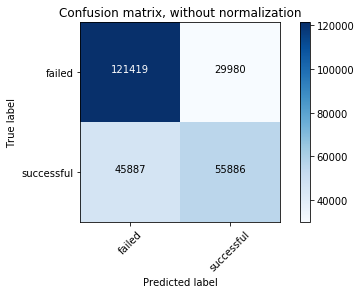

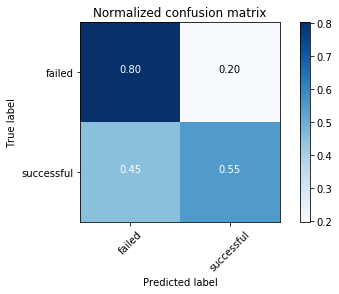

In [80]:
generate_confusion_matrix(expected_results, results, LABELS)

# Kickstarter DNN classifier eval

In [81]:
MODEL_PATH="gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02/model/1528279587"
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02",
                            "data","dataset_fields.json"), "r") as f:
    inputs_definition=json.load(f)
    
COLUMNS=inputs_definition["fields"]["columns"]
FIELD_TYPES=inputs_definition["fields"]["types"]
FIELD_CATEGORIES=inputs_definition["fields"]["categories"]
LABELS=inputs_definition["label"]["categories"]

In [83]:
with open_file(os.path.join("gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02",
                            "data","actual_evalset.csv"), "r") as f:
    df = pd.read_csv(f)
df.columns=[x.strip().replace(" ", "_").replace("_-_", "_") for x in df.columns]

In [84]:
BATCH_SIZE=15
ids=list(df["ID"].values)
requests=[]
expected_results=[]
results=[]
for i,h in enumerate(ids):
    feats=list(df[df["ID"]==h].drop(["state"], axis=1).values[0][1:])
    requests.append({
        "COLUMNS":COLUMNS,
        "FIELD_TYPES":FIELD_TYPES,
        "features":feats
    })
    expected_results.append(df[df["ID"]==h]["state"].values[0])
chunks = [requests[x:x+BATCH_SIZE] for x in xrange(0, len(requests), BATCH_SIZE)]

with TensorflowModelServer(
    {"kickstarter":MODEL_PATH}, 
    request_builder=build_estimator_request
) as tms:
    for i,c in enumerate(chunks):
        print((i,len(chunks)))
        results.extend(extract_outcomes(tms.predict(c)))

downloading models...
downloading kickstarter from gs://ml-research-injenia/estimators/trainings-kickstarter/dnn-classifier/test02/model/1528279587 to ./tensorflow_model_server_staging/kickstarter
model kickstarter downloaded to /notebooks/MIRCO/Estimators/tensorflow_model_server_staging/kickstarter
launching:
tensorflow_model_server --port=9000 --model_config_file=./tensorflow_model_server_staging/config.yaml
2018-06-08 07:28:29.251090: I tensorflow_serving/model_servers/server_core.cc:444] Adding/updating models.

2018-06-08 07:28:29.251156: I tensorflow_serving/model_servers/server_core.cc:499]  (Re-)adding model: kickstarter

2018-06-08 07:28:29.351681: I tensorflow_serving/core/basic_manager.cc:716] Successfully reserved resources to load servable {name: kickstarter version: 1}

2018-06-08 07:28:29.351719: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: kickstarter version: 1}

2018-06-08 07:28:29.351729: I tensorflow_serving/core/loader_

(489, 1876)
(490, 1876)
(491, 1876)
(492, 1876)
(493, 1876)
(494, 1876)
(495, 1876)
(496, 1876)
(497, 1876)
(498, 1876)
(499, 1876)
(500, 1876)
(501, 1876)
(502, 1876)
(503, 1876)
(504, 1876)
(505, 1876)
(506, 1876)
(507, 1876)
(508, 1876)
(509, 1876)
(510, 1876)
(511, 1876)
(512, 1876)
(513, 1876)
(514, 1876)
(515, 1876)
(516, 1876)
(517, 1876)
(518, 1876)
(519, 1876)
(520, 1876)
(521, 1876)
(522, 1876)
(523, 1876)
(524, 1876)
(525, 1876)
(526, 1876)
(527, 1876)
(528, 1876)
(529, 1876)
(530, 1876)
(531, 1876)
(532, 1876)
(533, 1876)
(534, 1876)
(535, 1876)
(536, 1876)
(537, 1876)
(538, 1876)
(539, 1876)
(540, 1876)
(541, 1876)
(542, 1876)
(543, 1876)
(544, 1876)
(545, 1876)
(546, 1876)
(547, 1876)
(548, 1876)
(549, 1876)
(550, 1876)
(551, 1876)
(552, 1876)
(553, 1876)
(554, 1876)
(555, 1876)
(556, 1876)
(557, 1876)
(558, 1876)
(559, 1876)
(560, 1876)
(561, 1876)
(562, 1876)
(563, 1876)
(564, 1876)
(565, 1876)
(566, 1876)
(567, 1876)
(568, 1876)
(569, 1876)
(570, 1876)
(571, 1876)
(572

(1159, 1876)
(1160, 1876)
(1161, 1876)
(1162, 1876)
(1163, 1876)
(1164, 1876)
(1165, 1876)
(1166, 1876)
(1167, 1876)
(1168, 1876)
(1169, 1876)
(1170, 1876)
(1171, 1876)
(1172, 1876)
(1173, 1876)
(1174, 1876)
(1175, 1876)
(1176, 1876)
(1177, 1876)
(1178, 1876)
(1179, 1876)
(1180, 1876)
(1181, 1876)
(1182, 1876)
(1183, 1876)
(1184, 1876)
(1185, 1876)
(1186, 1876)
(1187, 1876)
(1188, 1876)
(1189, 1876)
(1190, 1876)
(1191, 1876)
(1192, 1876)
(1193, 1876)
(1194, 1876)
(1195, 1876)
(1196, 1876)
(1197, 1876)
(1198, 1876)
(1199, 1876)
(1200, 1876)
(1201, 1876)
(1202, 1876)
(1203, 1876)
(1204, 1876)
(1205, 1876)
(1206, 1876)
(1207, 1876)
(1208, 1876)
(1209, 1876)
(1210, 1876)
(1211, 1876)
(1212, 1876)
(1213, 1876)
(1214, 1876)
(1215, 1876)
(1216, 1876)
(1217, 1876)
(1218, 1876)
(1219, 1876)
(1220, 1876)
(1221, 1876)
(1222, 1876)
(1223, 1876)
(1224, 1876)
(1225, 1876)
(1226, 1876)
(1227, 1876)
(1228, 1876)
(1229, 1876)
(1230, 1876)
(1231, 1876)
(1232, 1876)
(1233, 1876)
(1234, 1876)
(1235, 1876)

(1790, 1876)
(1791, 1876)
(1792, 1876)
(1793, 1876)
(1794, 1876)
(1795, 1876)
(1796, 1876)
(1797, 1876)
(1798, 1876)
(1799, 1876)
(1800, 1876)
(1801, 1876)
(1802, 1876)
(1803, 1876)
(1804, 1876)
(1805, 1876)
(1806, 1876)
(1807, 1876)
(1808, 1876)
(1809, 1876)
(1810, 1876)
(1811, 1876)
(1812, 1876)
(1813, 1876)
(1814, 1876)
(1815, 1876)
(1816, 1876)
(1817, 1876)
(1818, 1876)
(1819, 1876)
(1820, 1876)
(1821, 1876)
(1822, 1876)
(1823, 1876)
(1824, 1876)
(1825, 1876)
(1826, 1876)
(1827, 1876)
(1828, 1876)
(1829, 1876)
(1830, 1876)
(1831, 1876)
(1832, 1876)
(1833, 1876)
(1834, 1876)
(1835, 1876)
(1836, 1876)
(1837, 1876)
(1838, 1876)
(1839, 1876)
(1840, 1876)
(1841, 1876)
(1842, 1876)
(1843, 1876)
(1844, 1876)
(1845, 1876)
(1846, 1876)
(1847, 1876)
(1848, 1876)
(1849, 1876)
(1850, 1876)
(1851, 1876)
(1852, 1876)
(1853, 1876)
(1854, 1876)
(1855, 1876)
(1856, 1876)
(1857, 1876)
(1858, 1876)
(1859, 1876)
(1860, 1876)
(1861, 1876)
(1862, 1876)
(1863, 1876)
(1864, 1876)
(1865, 1876)
(1866, 1876)

Confusion matrix, without normalization
[[13246  3576]
 [ 5360  5948]]
Normalized confusion matrix
[[0.79 0.21]
 [0.47 0.53]]


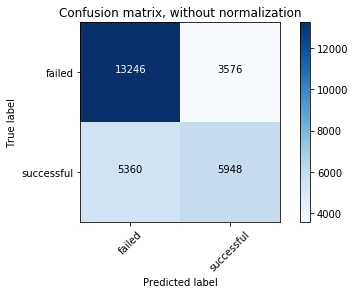

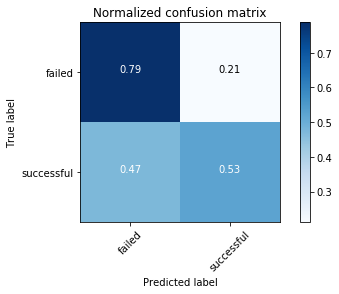

In [85]:
generate_confusion_matrix(expected_results, results, LABELS)

# -----------------------------------------------------------------------------------